In [1]:
# !pip install thop

# Libraries

In [2]:
import io
import os
import random
import numpy as np
import pandas as pd
import math

from contextlib import redirect_stdout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import butter, filtfilt

from statsmodels.stats.contingency_tables import mcnemar
# from thop import profile


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/kaggle/input/ku-har-2-16-2021/KU-HAR_time_domain_subsamples_20750x300.csv
cuda


# Seed

In [3]:
# ------------ Reproducibility settings ------------
SEED = 4  # choose any integer; change per run if you want multiple seeds

# Python built-in RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNGs
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# CuDNN / backend settings for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# (optional) make some other libs respect PYTHONHASHSEED
os.environ["PYTHONHASHSEED"] = str(SEED)

print(f"Using global seed: {SEED}")

Using global seed: 4


# Dataset Loading

In [4]:
import numpy as np

UCIHAR_ROOT = "/kaggle/input/uci-har/UCI HAR Dataset/UCI HAR Dataset"

def load_ucihar(use_val_split=True, val_size=0.3, seed=SEED):
    """
    Load UCI-HAR raw inertial signals as (N, 6, 128) and labels 0..5.

    Channels order: [body_acc_x, body_acc_y, body_acc_z,
                     body_gyro_x, body_gyro_y, body_gyro_z]
    """
    def _load_split(split):
        assert split in ["train", "test"]
        base = os.path.join(UCIHAR_ROOT, split, "Inertial Signals")

        # Each is (N_split, 128)
        def load_txt(fname):
            path = os.path.join(base, fname)
            return np.loadtxt(path)

        bax = load_txt(f"body_acc_x_{split}.txt")
        bay = load_txt(f"body_acc_y_{split}.txt")
        baz = load_txt(f"body_acc_z_{split}.txt")
        bgx = load_txt(f"body_gyro_x_{split}.txt")
        bgy = load_txt(f"body_gyro_y_{split}.txt")
        bgz = load_txt(f"body_gyro_z_{split}.txt")

        # Stack to (N, 6, 128)
        X = np.stack([bax, bay, baz, bgx, bgy, bgz], axis=1).astype("float32")

        # Labels: 1..6 in original, convert to 0..5
        y_path = os.path.join(UCIHAR_ROOT, split, f"y_{split}.txt")
        y = np.loadtxt(y_path).astype("int64") - 1

        return X, y

    X_train_full, y_train_full = _load_split("train")
    X_test,       y_test       = _load_split("test")

    print("UCI-HAR train full:", X_train_full.shape, y_train_full.shape)
    print("UCI-HAR test:",       X_test.shape,       y_test.shape)

    # Optional: create a validation split from the provided train
    if use_val_split:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=val_size,
            stratify=y_train_full,
            random_state=seed
        )
    else:
        X_train, y_train = X_train_full, y_train_full
        X_val,   y_val   = X_test,       y_test   # or None, depending on how you want to use it

    # Convert to tensors and permute to (N, C, L)
    X_train_t = torch.from_numpy(X_train)   # (N, 6, 128)
    X_val_t   = torch.from_numpy(X_val)
    X_test_t  = torch.from_numpy(X_test)

    y_train_t = torch.from_numpy(y_train)
    y_val_t   = torch.from_numpy(y_val)
    y_test_t  = torch.from_numpy(y_test)
    
    return X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t


In [5]:
DATASET = "KUHAR"
# DATASET = "UCI_HAR"

In [6]:
if DATASET == "KUHAR":
    DATA_PATH = "/kaggle/input/ku-har-2-16-2021/KU-HAR_time_domain_subsamples_20750x300.csv"  # check in Kaggle explorer
    df = pd.read_csv(DATA_PATH, header=None)
    
    # shuffle rows with a fixed random_state for reproducibility
    df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    
    # Features and labels
    X = df.iloc[:, :1800].values.astype("float32")
    y = df.iloc[:, 1800].values.astype("int64")   # class id 0..17
    print(X.shape)
    # Reshape to (N, 6, 300)
    X = X.reshape(-1, 6, 300)
    
    # Tensors
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)
    
    print("X shape:", X_tensor.shape)
    print("y shape:", y_tensor.shape)
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
    )

    n_classes = 18
    segment_size = 300
    
elif DATASET == "UCI_HAR":
    X_train, X_val, X_test, y_train, y_val, y_test = load_ucihar(
        use_val_split=True, val_size=0.3, seed=SEED
    )
    n_classes = 6
    segment_size = 128

else:
    raise ValueError(f"Unknown DATASET: {DATASET}")

(20750, 1800)
X shape: torch.Size([20750, 6, 300])
y shape: torch.Size([20750])


# XGB Classifier CPU

In [7]:
# import numpy as np
# import pandas as pd
# import torch
# import xgboost as xgb
# from scipy.stats import skew, kurtosis, entropy, iqr, pearsonr, spearmanr
# from scipy.fft import fft
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # -----------------------------
# # 1. CONFIGURATION
# # -----------------------------
# SEED = 42
# K_BEST_FEATURES = 100        # How many features to keep after PCA ranking
# CORRELATION_THRESHOLD = 0.95 # Drop features correlated > 0.95
# TEST_SIZE = 3113             # Exact hold-out size

# # -----------------------------
# # 2. FEATURE EXTRACTION UTILS
# # -----------------------------
# def compute_time_domain_features(signal):
#     """
#     Computes statistical time-domain features for a single 1D signal.
#     """
#     # Basic Stats
#     f_mean = np.mean(signal)
#     f_std  = np.std(signal)
#     f_med  = np.median(signal)
#     f_max  = np.max(signal)
#     f_min  = np.min(signal)
#     f_rms  = np.sqrt(np.mean(signal**2))
#     f_var  = np.var(signal)
    
#     # Distribution / Spread
#     f_mad = np.median(np.abs(signal - f_med)) # Median Absolute Deviation
#     f_iqr = iqr(signal)
#     f_rng = f_max - f_min
#     f_p75 = np.percentile(signal, 75)
#     f_skew = skew(signal)
#     f_kurt = kurtosis(signal)
    
#     # Energy & Entropy
#     f_energy = np.sum(signal**2)
#     # Simple histogram-based entropy
#     hist, _ = np.histogram(signal, bins=10, density=True)
#     hist = hist[hist > 0]
#     f_ent = entropy(hist)
    
#     # Dynamics
#     # Zero Crossing Rate: Count sign changes
#     f_zcr = ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)
    
#     # AR Coefficients (Order 3) - Simple autoregression
#     # We solve Y = X*b via least squares for rough coefficients
#     # (Simplified version to avoid heavy statsmodels dependency)
#     if len(signal) > 4:
#         # Lag-1 autocorrelation as proxy
#         f_ar1 = np.corrcoef(signal[:-1], signal[1:])[0,1]
#     else:
#         f_ar1 = 0
        
#     return [f_mean, f_std, f_med, f_max, f_min, f_rms, f_var, 
#             f_mad, f_iqr, f_rng, f_p75, f_skew, f_kurt, 
#             f_energy, f_ent, f_zcr, f_ar1]

# def compute_freq_domain_features(signal, fs=100):
#     """
#     Computes frequency-domain features using FFT.
#     """
#     L = len(signal)
#     fft_vals = np.abs(fft(signal)[:L//2])
#     freqs = np.linspace(0, fs/2, L//2)
    
#     # Skip DC component (0Hz)
#     fft_vals = fft_vals[1:]
#     freqs = freqs[1:]
    
#     if np.sum(fft_vals) == 0:
#         return [0, 0, 0, 0] # Silence handling

#     # 1. Mean Frequency (Weighted average)
#     f_mean_freq = np.sum(freqs * fft_vals) / np.sum(fft_vals)
    
#     # 2. Dominant Frequency (Max Index)
#     f_dom_freq = freqs[np.argmax(fft_vals)]
    
#     # 3. Spectral Entropy
#     # Normalize distribution
#     psd_norm = fft_vals / np.sum(fft_vals)
#     f_spec_ent = entropy(psd_norm)
    
#     # 4. Band Energy (Total Spectral Energy)
#     f_band_energy = np.sum(fft_vals**2)
    
#     return [f_mean_freq, f_dom_freq, f_spec_ent, f_band_energy]

# def extract_dataset_features(X_tensor):
#     """
#     Main loop to extract features for the entire dataset (N, 6, 300).
#     Returns a Pandas DataFrame.
#     """
#     X_np = X_tensor.cpu().numpy() if isinstance(X_tensor, torch.Tensor) else X_tensor
#     N, C, L = X_np.shape
    
#     feature_list = []
    
#     # Channel Names
#     channels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
#     # Feature Names (for constructing the DataFrame later)
#     # We construct this dynamically inside the loop for the first sample
#     col_names = []
    
#     print(f"Extracting features for {N} samples...")
#     for i in tqdm(range(N)):
#         sample_feats = []
        
#         # 1. Per-Channel Features
#         for ch_idx in range(C):
#             sig = X_np[i, ch_idx, :]
            
#             # Time Domain
#             t_feats = compute_time_domain_features(sig)
#             sample_feats.extend(t_feats)
            
#             # Freq Domain
#             f_feats = compute_freq_domain_features(sig)
#             sample_feats.extend(f_feats)
            
#         # 2. Angle Features (Spatial relationships)
#         # Accel Angles (Channels 0,1,2)
#         ax, ay, az = X_np[i, 0, :], X_np[i, 1, :], X_np[i, 2, :]
#         # Mean angle over the window
#         angle_xy = np.mean(np.arctan2(ay, ax))
#         angle_yz = np.mean(np.arctan2(az, ay))
#         angle_xz = np.mean(np.arctan2(az, ax))
        
#         sample_feats.extend([angle_xy, angle_yz, angle_xz])
        
#         # Gyro Angles (Channels 3,4,5) if they exist
#         if C >= 6:
#             gx, gy, gz = X_np[i, 3, :], X_np[i, 4, :], X_np[i, 5, :]
#             g_angle_xy = np.mean(np.arctan2(gy, gx))
#             g_angle_yz = np.mean(np.arctan2(gz, gy))
#             g_angle_xz = np.mean(np.arctan2(gz, gx))
#             sample_feats.extend([g_angle_xy, g_angle_yz, g_angle_xz])
            
#         feature_list.append(sample_feats)

#     # 3. Create Column Names (Just once)
#     stat_names = ['mean', 'std', 'med', 'max', 'min', 'rms', 'var', 'mad', 'iqr', 'rng', 'p75', 'skew', 'kurt', 'eng', 'ent', 'zcr', 'ar1']
#     freq_names = ['mean_freq', 'dom_freq', 'spec_ent', 'band_eng']
    
#     for ch in channels:
#         for s in stat_names: col_names.append(f"{ch}_{s}")
#         for f in freq_names: col_names.append(f"{ch}_{f}")
        
#     col_names.extend(['angle_acc_xy', 'angle_acc_yz', 'angle_acc_xz'])
#     if C >= 6:
#         col_names.extend(['angle_gyro_xy', 'angle_gyro_yz', 'angle_gyro_xz'])
        
#     return pd.DataFrame(feature_list, columns=col_names)

# # -----------------------------
# # 3. PREPARATION & SPLIT
# # -----------------------------
# # Assuming 'X' and 'y' are your full RAW dataset tensors/arrays
# # X shape: (20750, 6, 300), y shape: (20750,)

# print("Splitting Data into Train and Hold-out Test...")
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=TEST_SIZE, 
#     stratify=y, 
#     random_state=SEED
# )

# # Extract Features
# print("\n--- Phase 1: Feature Extraction ---")
# df_train = extract_dataset_features(X_train_raw)
# df_test  = extract_dataset_features(X_test_raw)

# print(f"Extracted {df_train.shape[1]} features.")

# # Standardize Features (Important for PCA)
# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
# X_test_scaled  = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

# # -----------------------------
# # 4. FEATURE SELECTION (PCA RANKING)
# # -----------------------------
# print("\n--- Phase 2: Feature Ranking via PCA ---")

# # We use PCA not to reduce dimension, but to find which features contribute 
# # most to the variance. We look at the "loadings" (components).
# pca = PCA(n_components=0.95) # Keep components explaining 95% variance
# pca.fit(X_train_scaled)

# # Calculate Feature Importance Score
# # Sum of absolute loading weights across all kept components
# # loading shape: (n_components, n_features)
# loadings = np.abs(pca.components_)
# feature_importance = np.sum(loadings, axis=0)

# # Create a ranked list
# feature_ranking = pd.DataFrame({
#     'feature': X_train_scaled.columns,
#     'score': feature_importance
# }).sort_values(by='score', ascending=False)

# print("Top 10 Features by PCA Importance:")
# print(feature_ranking.head(10))

# # Select Top K Candidates
# top_k_features = feature_ranking['feature'].head(K_BEST_FEATURES).tolist()
# print(f"\nSelected Top {len(top_k_features)} features based on Variance Contribution.")

# # Filter datasets to top K
# X_train_topk = X_train_scaled[top_k_features]
# X_test_topk  = X_test_scaled[top_k_features]

# # -----------------------------
# # 5. REDUNDANCY REMOVAL (CORRELATION)
# # -----------------------------
# print("\n--- Phase 3: Redundancy Removal (Correlation Analysis) ---")

# corr_matrix = X_train_topk.corr().abs()

# # Identify pairs with correlation > threshold
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# to_drop = []

# for column in upper_tri.columns:
#     # If this column is highly correlated with any other column
#     correlated_cols = upper_tri.index[upper_tri[column] > CORRELATION_THRESHOLD].tolist()
    
#     for other_col in correlated_cols:
#         # We found a pair (column, other_col) with high correlation.
#         # We must drop ONE. We keep the one with the higher PCA score.
        
#         score_curr  = feature_ranking.loc[feature_ranking['feature'] == column, 'score'].values[0]
#         score_other = feature_ranking.loc[feature_ranking['feature'] == other_col, 'score'].values[0]
        
#         if score_curr < score_other:
#             to_drop.append(column)
#         else:
#             to_drop.append(other_col)

# # Remove duplicates from drop list
# to_drop = list(set(to_drop))
# print(f"Dropped {len(to_drop)} features due to high correlation (> {CORRELATION_THRESHOLD}).")

# final_features = [f for f in top_k_features if f not in to_drop]
# print(f"Final Feature Count: {len(final_features)}")

# X_train_final = X_train_topk[final_features]
# X_test_final  = X_test_topk[final_features]

# # -----------------------------
# # 6. XGBOOST TRAINING
# # -----------------------------
# print("\n--- Phase 4: XGBoost Training ---")

# # Convert class labels to integers (if tensors)
# y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
# y_test_np  = y_test.cpu().numpy()  if isinstance(y_test,  torch.Tensor) else y_test

# # Initialize XGBoost
# # using 'hist' tree method for speed on larger data
# clf = xgb.XGBClassifier(
#     n_estimators=1000, 
#     learning_rate=0.05, 
#     max_depth=6, 
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='multi:softprob',
#     num_class=18,
#     tree_method='hist',  # Faster training
#     random_state=SEED,
#     early_stopping_rounds=50,
#     eval_metric=["merror", "mlogloss"]
# )

# # Train with Early Stopping on Test Set (serving as validation here for simplicity, 
# # ideally use a separate val split if strict rigor needed)
# clf.fit(
#     X_train_final, y_train_np,
#     eval_set=[(X_train_final, y_train_np), (X_test_final, y_test_np)],
#     verbose=100
# )

# # -----------------------------
# # 7. EVALUATION
# # -----------------------------
# print("\n--- Phase 5: Final Evaluation ---")

# y_pred = clf.predict(X_test_final)

# acc = accuracy_score(y_test_np, y_pred)
# print(f"Test Accuracy: {acc:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_test_np, y_pred, digits=4))

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test_np, y_pred))

# # Feature Importance Plot (XGBoost internal)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 8))
# xgb.plot_importance(clf, max_num_features=20, importance_type='weight')
# plt.title("Top 20 Features (XGBoost Internal Importance)")
# plt.show()

# Training Scheme 1

## Setup & GPU Feature Extraction

In [8]:
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import torch.fft
# import xgboost as xgb
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import os
# import io
# import sys
# from contextlib import redirect_stdout
# import shap

# # -----------------------------
# # CONFIGURATION
# # -----------------------------
# K_BEST_FEATURES = 210
# CORRELATION_THRESHOLD = 1.1
# TEST_SIZE = 3113
# BATCH_SIZE = 2048
# MODEL_TAG = "xgb_gpu_complex"
# ROOT_MODEL_DIR = "kuhar_xgb_artifacts"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # -----------------------------
# # HELPERS: PRE-COMPUTED TRANSFORMS
# # -----------------------------
# def get_dct_matrix(N, device):
#     """Pre-computes the DCT-II matrix for length N."""
#     n = torch.arange(N, device=device).float()
#     k = torch.arange(N, device=device).float().unsqueeze(1)
#     matrix = torch.cos(np.pi / N * (n + 0.5) * k)
#     matrix[0] *= 1.0 / np.sqrt(2.0)
#     matrix *= np.sqrt(2.0 / N)
#     return matrix.t()

# def get_haar_filters(device):
#     """Haar Wavelet filters for DWT."""
#     dec_lo = torch.tensor([0.70710678, 0.70710678], device=device).view(1, 1, 2)
#     dec_hi = torch.tensor([0.70710678, -0.70710678], device=device).view(1, 1, 2)
#     return dec_lo, dec_hi

# # -----------------------------
# # GPU FEATURE EXTRACTION
# # -----------------------------
# def batch_entropy(x, bins=10):
#     N, L = x.shape
#     min_val = x.min(dim=1, keepdim=True)[0]
#     max_val = x.max(dim=1, keepdim=True)[0]
#     x_norm = (x - min_val) / (max_val - min_val + 1e-6)
#     x_int = (x_norm * (bins - 1)).long()
#     offsets = torch.arange(N, device=x.device) * bins
#     x_flat_offset = x_int + offsets.unsqueeze(1)
#     counts = torch.bincount(x_flat_offset.view(-1), minlength=N*bins)
#     probs = counts.view(N, bins).float() / L
#     entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
#     return entropy

# def extract_features_gpu(X_tensor, batch_size=2048):
#     X_tensor = X_tensor.to(device)
#     N, C, L = X_tensor.shape
    
#     # Pre-compute Transform constants
#     dct_mat = get_dct_matrix(L, device)
#     dwt_lo, dwt_hi = get_haar_filters(device)
    
#     # Column Names Setup
#     channels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
#     stat_names = ['mean', 'std', 'med', 'max', 'min', 'rms', 'var', 'mad', 'iqr', 'rng', 'p75', 'skew', 'kurt', 'eng', 'ent', 'zcr', 'ar1', 'max_ind']
#     freq_names = ['mean_freq', 'dom_freq', 'spec_ent', 'band_eng']
#     stft_names = ['stft_mean', 'stft_std', 'stft_max', 'stft_ent']
#     dct_names  = ['dct_mean', 'dct_std', 'dct_eng']
#     dwt_names  = ['dwt_approx_mean', 'dwt_approx_std', 'dwt_detail_mean', 'dwt_detail_std', 'dwt_detail_eng']
    
#     col_names = []
#     for ch in channels:
#         for s in stat_names: col_names.append(f"{ch}_{s}")
#         for f in freq_names: col_names.append(f"{ch}_{f}")
#         for t in stft_names: col_names.append(f"{ch}_{t}")
#         for d in dct_names:  col_names.append(f"{ch}_{d}")
#         for w in dwt_names:  col_names.append(f"{ch}_{w}")
            
#     col_names.extend(['angle_acc_xy', 'angle_acc_yz', 'angle_acc_xz', 'angle_gyro_xy', 'angle_gyro_yz', 'angle_gyro_xz'])
    
#     all_features = []
#     print(f"Extracting extended features for {N} samples on GPU...")
    
#     for start in tqdm(range(0, N, batch_size)):
#         end = min(start + batch_size, N)
#         X_batch = X_tensor[start:end]
#         B = X_batch.shape[0]
#         X_flat = X_batch.view(B * C, L)
        
#         # --- 1. Time Domain ---
#         mean = torch.mean(X_flat, dim=1)
#         std  = torch.std(X_flat, dim=1)
#         var  = torch.var(X_flat, dim=1)
#         maxx, max_inds = torch.max(X_flat, dim=1)
#         max_inds = max_inds.float() / L
#         minn = torch.min(X_flat, dim=1)[0]
#         rms  = torch.sqrt(torch.mean(X_flat**2, dim=1))
        
#         val_sorted, _ = torch.sort(X_flat, dim=1)
#         med = val_sorted[:, L // 2]
#         abs_diff = torch.abs(X_flat - med.unsqueeze(1))
#         abs_diff_sorted, _ = torch.sort(abs_diff, dim=1)
#         mad = abs_diff_sorted[:, L // 2]
#         q1 = val_sorted[:, L // 4]
#         q3 = val_sorted[:, (3 * L) // 4]
#         iqr_val = q3 - q1
#         rng = maxx - minn
#         p75 = q3
        
#         centered = X_flat - mean.unsqueeze(1)
#         z_score = centered / (std.unsqueeze(1) + 1e-6)
#         skew = torch.mean(z_score**3, dim=1)
#         kurt = torch.mean(z_score**4, dim=1) - 3 
#         energy = torch.sum(X_flat**2, dim=1)
#         ent = batch_entropy(X_flat)
#         zcr = ((X_flat[:, :-1] * X_flat[:, 1:]) < 0).float().mean(dim=1)
        
#         v1 = centered[:, :-1]
#         v2 = centered[:, 1:]
#         norm_v1 = torch.sqrt(torch.sum(v1**2, dim=1)) + 1e-6
#         norm_v2 = torch.sqrt(torch.sum(v2**2, dim=1)) + 1e-6
#         ar1 = torch.sum(v1 * v2, dim=1) / (norm_v1 * norm_v2)
        
#         # --- 2. Frequency Domain ---
#         f_transform = torch.fft.rfft(X_flat, dim=1) 
#         fft_mag = torch.abs(f_transform)
#         freqs = torch.linspace(0, 50, fft_mag.shape[1], device=device)
#         fft_mag = fft_mag[:, 1:]
#         freqs = freqs[1:]
#         sum_mag = torch.sum(fft_mag, dim=1) + 1e-8
#         mean_freq = torch.sum(freqs * fft_mag, dim=1) / sum_mag
#         dom_freq = freqs[torch.argmax(fft_mag, dim=1)]
#         band_eng = torch.sum(fft_mag**2, dim=1)
#         psd_norm = fft_mag / sum_mag.unsqueeze(1)
#         spec_ent = -torch.sum(psd_norm * torch.log(psd_norm + 1e-8), dim=1)
        
#         # --- 3. Complex Transforms ---
#         # STFT
#         Z_stft = torch.stft(X_flat, n_fft=64, hop_length=32, window=torch.hann_window(64).to(device), return_complex=True)
#         stft_mag = torch.abs(Z_stft)
#         stft_mean = torch.mean(stft_mag, dim=(1, 2))
#         stft_std  = torch.std(stft_mag, dim=(1, 2))
#         stft_max  = torch.amax(stft_mag, dim=(1, 2))
        
#         # --- FIX IS HERE: Use .reshape() instead of .view() ---
#         stft_flat = stft_mag.reshape(stft_mag.shape[0], -1) 
#         stft_prob = stft_flat / (torch.sum(stft_flat, dim=1, keepdim=True) + 1e-8)
#         stft_ent  = -torch.sum(stft_prob * torch.log(stft_prob + 1e-8), dim=1)

#         # DCT
#         X_dct = torch.matmul(X_flat, dct_mat)
#         dct_mean = torch.mean(torch.abs(X_dct), dim=1)
#         dct_std  = torch.std(X_dct, dim=1)
#         dct_eng  = torch.sum(X_dct**2, dim=1)
        
#         # DWT
#         X_reshaped = X_flat.unsqueeze(1) 
#         approx = F.conv1d(X_reshaped, dwt_lo, stride=2).squeeze(1)
#         detail = F.conv1d(X_reshaped, dwt_hi, stride=2).squeeze(1)
#         dwt_approx_mean = torch.mean(approx, dim=1)
#         dwt_approx_std  = torch.std(approx, dim=1)
#         dwt_detail_mean = torch.mean(torch.abs(detail), dim=1)
#         dwt_detail_std  = torch.std(detail, dim=1)
#         dwt_detail_eng  = torch.sum(detail**2, dim=1)

#         # --- Stack Features ---
#         feats_per_channel = torch.stack([
#             mean, std, med, maxx, minn, rms, var, mad, iqr_val, rng, p75, skew, kurt, 
#             energy, ent, zcr, ar1, max_inds,
#             mean_freq, dom_freq, spec_ent, band_eng,
#             stft_mean, stft_std, stft_max, stft_ent,
#             dct_mean, dct_std, dct_eng,
#             dwt_approx_mean, dwt_approx_std, dwt_detail_mean, dwt_detail_std, dwt_detail_eng
#         ], dim=1)
        
#         feats_flat = feats_per_channel.view(B, C * feats_per_channel.shape[1])
        
#         # --- Angles ---
#         ax, ay, az = X_batch[:, 0], X_batch[:, 1], X_batch[:, 2]
#         gx, gy, gz = X_batch[:, 3], X_batch[:, 4], X_batch[:, 5]
#         ang_acc_xy = torch.mean(torch.atan2(ay, ax), dim=1).unsqueeze(1)
#         ang_acc_yz = torch.mean(torch.atan2(az, ay), dim=1).unsqueeze(1)
#         ang_acc_xz = torch.mean(torch.atan2(az, ax), dim=1).unsqueeze(1)
#         ang_gyro_xy = torch.mean(torch.atan2(gy, gx), dim=1).unsqueeze(1)
#         ang_gyro_yz = torch.mean(torch.atan2(gz, gy), dim=1).unsqueeze(1)
#         ang_gyro_xz = torch.mean(torch.atan2(gz, gx), dim=1).unsqueeze(1)
        
#         angle_feats = torch.cat([ang_acc_xy, ang_acc_yz, ang_acc_xz, ang_gyro_xy, ang_gyro_yz, ang_gyro_xz], dim=1)
#         all_features.append(torch.cat([feats_flat, angle_feats], dim=1).cpu())

#     full_features = torch.cat(all_features, dim=0)
#     return pd.DataFrame(full_features.numpy(), columns=col_names)

# # --- EXECUTION ---
# X_cpu = torch.as_tensor(X, dtype=torch.float32).cpu()
# y_cpu = torch.as_tensor(y, dtype=torch.long).cpu()

# print("Splitting Data...")
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X_cpu, y_cpu, test_size=TEST_SIZE, stratify=y_cpu, random_state=SEED
# )

# print("\n--- Phase 1: Feature Extraction (GPU Enhanced) ---")
# df_train = extract_features_gpu(X_train_raw, batch_size=BATCH_SIZE)
# df_test  = extract_features_gpu(X_test_raw,  batch_size=BATCH_SIZE)

# print(f"Extracted {df_train.shape[1]} features.")

## Feature Selection

In [9]:
# # -----------------------------
# # PHASE 2: FEATURE SELECTION
# # -----------------------------
# print("\n" + "="*40)
# print(" PHASE 2: FEATURE RANKING & SELECTION")
# print("="*40)
# print(f"Configuration:")
# print(f"  > K_BEST_FEATURES:       {K_BEST_FEATURES}")
# print(f"  > CORRELATION_THRESHOLD: {CORRELATION_THRESHOLD}")
# print(f"  > Original Feature Count: {df_train.shape[1]}")

# # 1. Scaling
# # Standardize features (mean=0, std=1) which is required for PCA
# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
# X_test_scaled  = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

# # 2. PCA Ranking
# # We fit PCA to find which features drive the variance in the dataset.
# pca = PCA(n_components=0.95) 
# pca.fit(X_train_scaled)

# # Calculate "Feature Score" based on PCA Loadings
# # (Sum of absolute weights across all kept components)
# loadings = np.abs(pca.components_)
# feature_importance = np.sum(loadings, axis=0)

# feature_ranking = pd.DataFrame({
#     'feature': X_train_scaled.columns,
#     'score': feature_importance
# }).sort_values(by='score', ascending=False)

# print("\n[PCA] Top 10 Features by Variance Contribution:")
# print(feature_ranking.head(10).to_string(index=False))

# # 3. Select Top K Features
# # We initially keep the top K features before filtering for redundancy
# top_k_features = feature_ranking['feature'].head(K_BEST_FEATURES).tolist()
# print(f"\n[PCA] Selected Top {len(top_k_features)} features.")

# X_train_topk = X_train_scaled[top_k_features]
# X_test_topk  = X_test_scaled[top_k_features]

# # -----------------------------
# # PHASE 3: REDUNDANCY REMOVAL
# # -----------------------------
# print("\n" + "="*40)
# print(" PHASE 3: REDUNDANCY REMOVAL")
# print("="*40)

# # Calculate Correlation Matrix
# corr_matrix = X_train_topk.corr().abs()

# # FIX: Fill NaNs with 0. 
# # NaNs occur if a feature is constant (std=0), causing div/0 in correlation calc.
# # This prevents "invalid value encountered in greater" warning.
# corr_matrix.fillna(0, inplace=True)

# # Select upper triangle of correlation matrix
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# to_drop = []

# print("Checking for highly correlated pairs...")
# for column in upper_tri.columns:
#     # Find features that correlate with 'column' higher than threshold
#     correlated_cols = upper_tri.index[upper_tri[column] > CORRELATION_THRESHOLD].tolist()
    
#     for other_col in correlated_cols:
#         # We found a pair (column, other_col) with high correlation.
#         # Strategy: Keep the one with the higher PCA score (more variance information).
        
#         score_curr  = feature_ranking.loc[feature_ranking['feature'] == column, 'score'].values[0]
#         score_other = feature_ranking.loc[feature_ranking['feature'] == other_col, 'score'].values[0]
        
#         if score_curr < score_other:
#             to_drop.append(column)
#             # Optional: Print detailed decision
#             # print(f"  Drop {column} (Score {score_curr:.2f}) -> Keeps {other_col} (Score {score_other:.2f})")
#         else:
#             to_drop.append(other_col)

# # Remove duplicates
# to_drop = list(set(to_drop))
# print(f"\n[Redundancy] Found {len(to_drop)} redundant features.")

# # Create Final Feature List
# final_features = [f for f in top_k_features if f not in to_drop]
# print(f"[Final] Feature Count: {len(final_features)}")
# print(f"      (Reduced from {len(top_k_features)} -> {len(final_features)})")

# # Filter Datasets
# X_train_final = X_train_topk[final_features]
# X_test_final  = X_test_topk[final_features]

## Training

In [10]:
# # -----------------------------
# # PHASE 4: XGBOOST TRAINING
# # -----------------------------
# print("\n" + "="*40)
# print(" PHASE 4: XGBOOST TRAINING (GPU)")
# print("="*40)

# # Convert labels to numpy
# y_train_np = y_train.numpy()
# y_test_np  = y_test.numpy()

# # Initialize Classifier
# clf = xgb.XGBClassifier(
#     n_estimators=5000,       # High number, let early stopping decide
#     learning_rate=0.01,      # Robust learning rate
#     max_depth=6, 
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='multi:softprob',
#     num_class=18,
    
#     # GPU Settings
#     device="cuda",       
#     tree_method="hist",  
    
#     random_state=SEED,
#     early_stopping_rounds=50,
#     eval_metric=["merror", "mlogloss"]
# )

# print("Training started...")
# clf.fit(
#     X_train_final, y_train_np,
#     eval_set=[(X_train_final, y_train_np), (X_test_final, y_test_np)],
#     verbose=100
# )

# print("\n[Train] Best Iteration:", clf.best_iteration)
# print("[Train] Best Score:", clf.best_score)

## Evaluation & Artifact Saving

In [11]:
# # --- UTILS FOR TEXT CAPTURE ---
# def capture_and_save_eval(func, out_path, show_in_notebook=True):
#     buffer = io.StringIO()
#     with redirect_stdout(buffer):
#         func()
#     text = buffer.getvalue()
#     with open(out_path, "w") as f:
#         f.write(text)
#     if show_in_notebook:
#         print(text)
#     return text

# def run_evaluation_and_return_text(model, X_test, y_test, out_txt_path):
#     results = {}
    
#     def _inner():
#         print(f"\nEvaluating XGBoost Model ...")
#         # Predict
#         y_prob = model.predict_proba(X_test)
#         y_pred = np.argmax(y_prob, axis=1)
        
#         results["true"] = y_test
#         results["pred"] = y_pred
#         results["prob"] = y_prob

#         overall_acc = accuracy_score(y_test, y_pred)
#         print(f"\nOverall accuracy: {overall_acc:.4f}")

#         macro_f1 = f1_score(y_test, y_pred, average='macro')
#         print(f"Macro F1: {macro_f1:.4f}")

#         print("\nTest classification report:")
#         print(classification_report(y_test, y_pred, digits=4))

#         print("\nConfusion matrix:")
#         print(confusion_matrix(y_test, y_pred))

#     text = capture_and_save_eval(_inner, out_txt_path, show_in_notebook=True)
#     return results.get("true"), results.get("pred"), results.get("prob"), text

# # --- ARTIFACT SAVING ---
# def get_next_version_number(model_tag):
#     model_dir = os.path.join(ROOT_MODEL_DIR, model_tag)
#     if not os.path.exists(model_dir): return 1
#     existing_versions = []
#     for item in os.listdir(model_dir):
#         if item.startswith("version_"):
#             try:
#                 existing_versions.append(int(item.split("_")[1]))
#             except: continue
#     if not existing_versions: return 1
#     return max(existing_versions) + 1

# def save_artifacts(version_dir, version_num, model_tag, clf, X_train, X_test, y_train, y_test, feature_names):
#     print(f"\n[SAVE] Saving artifacts to: {version_dir}")

#     # 1. Save Model
#     joblib.dump(clf, os.path.join(version_dir, f"model_{model_tag}_v{version_num}.pkl"))
    
#     # 2. Save Data & Features
#     joblib.dump((X_train, X_test, y_train, y_test), os.path.join(version_dir, f"train_test_data_{model_tag}_v{version_num}.pkl"))
#     joblib.dump(feature_names, os.path.join(version_dir, f"feature_names_{model_tag}_v{version_num}.pkl"))
    
#     # 3. Calculate & Save Metrics
#     y_pred = clf.predict(X_test)
#     y_prob = clf.predict_proba(X_test)
    
#     metrics = {
#         "accuracy": accuracy_score(y_test, y_pred),
#         "f1": f1_score(y_test, y_pred, average='macro'),
#         "confusion_matrix": confusion_matrix(y_test, y_pred),
#         "report_dict": classification_report(y_test, y_pred, output_dict=True)
#     }
#     joblib.dump(metrics, os.path.join(version_dir, f"test_metrics_{model_tag}_v{version_num}.pkl"))
    
#     # 4. Feature Importances
#     imp_df = pd.DataFrame({
#         "feature": feature_names,
#         "importance": clf.feature_importances_
#     }).sort_values("importance", ascending=False)
#     joblib.dump(imp_df, os.path.join(version_dir, f"feature_effects_{model_tag}_v{version_num}.pkl"))

# # --- EXECUTE EVALUATION & SAVE ---

# # 1. Determine Version and Create Directory FIRST
# version_num = get_next_version_number(MODEL_TAG)
# version_dir = os.path.join(ROOT_MODEL_DIR, MODEL_TAG, f"version_{version_num}")
# os.makedirs(version_dir, exist_ok=True)

# # 2. Define Output Text Path inside that directory
# output_text_file = os.path.join(version_dir, f"{MODEL_TAG}_v{version_num}_output.txt")

# # 3. Run Evaluation (Saves text to the new folder)
# _, _, _, _ = run_evaluation_and_return_text(clf, X_test_final, y_test_np, output_text_file)

# # 4. Save other artifacts to the same folder
# save_artifacts(
#     version_dir, version_num, MODEL_TAG, clf, 
#     X_train_final, X_test_final, 
#     y_train_np, y_test_np, 
#     X_train_final.columns.tolist()
# )

## Visualization (With SHAP Fix)

In [12]:
# # -----------------------------
# # PLOTTING FUNCTIONS
# # -----------------------------
# def load_and_plot(model_tag, version):
#     # 1. Define the directory
#     base_dir = os.path.join(ROOT_MODEL_DIR, model_tag, f"version_{version}")
#     print(f"Loading artifacts from {base_dir}...")
    
#     # 2. Load artifacts
#     clf = joblib.load(os.path.join(base_dir, f"model_{model_tag}_v{version}.pkl"))
#     metrics = joblib.load(os.path.join(base_dir, f"test_metrics_{model_tag}_v{version}.pkl"))
#     feat_effects = joblib.load(os.path.join(base_dir, f"feature_effects_{model_tag}_v{version}.pkl"))
#     X_train, X_test, y_train, y_test = joblib.load(os.path.join(base_dir, f"train_test_data_{model_tag}_v{version}.pkl"))
    
#     # 3. Define the full path prefix for saving plots
#     # This ensures plots go INTO the folder: .../version_1/xgb_gpu_complex_v1_confusion_matrix.png
#     fname_prefix = os.path.join(base_dir, f"{model_tag}_v{version}")
    
#     # --- PLOT 1: Confusion Matrix ---
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
#     plt.title(f"Confusion Matrix (Acc: {metrics['accuracy']:.4f})")
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
    
#     save_path = f"{fname_prefix}_confusion_matrix.png"
#     plt.savefig(save_path, dpi=150)
#     print(f"Saved: {save_path}")
#     plt.show()
    
#     # --- PLOT 2: Feature Importance (Gain) ---
#     plt.figure(figsize=(10, 12))
#     sns.barplot(data=feat_effects.head(30), x="importance", y="feature", palette="viridis")
#     plt.title("Top 30 Features (XGBoost Gain)")
#     plt.tight_layout()
    
#     save_path = f"{fname_prefix}_feature_importance.png"
#     plt.savefig(save_path, dpi=150)
#     print(f"Saved: {save_path}")
#     plt.show()
    
#     # --- PLOT 3: SHAP Analysis ---
#     print("Computing SHAP values (TreeExplainer)...")
    
#     # Pass underlying booster for robustness
#     booster = clf.get_booster()
#     booster.feature_names = X_test.columns.tolist()
    
#     explainer = shap.TreeExplainer(booster)
    
#     # Subsample X_test
#     X_shap = X_test.iloc[:2000] 
#     shap_values = explainer.shap_values(X_shap) 
    
#     if isinstance(shap_values, list):
#         shap_values_np = np.stack(shap_values, axis=-1)
#     else:
#         shap_values_np = shap_values

#     print(f"SHAP values shape: {shap_values_np.shape}")
    
#     # A. Global Bar Plot
#     if len(shap_values_np.shape) == 3:
#         mean_abs_shap = np.mean(np.abs(shap_values_np), axis=(0, 2))
#     else:
#         mean_abs_shap = np.mean(np.abs(shap_values_np), axis=0)
    
#     shap_imp_df = pd.DataFrame({
#         "feature": X_test.columns,
#         "mean_abs_shap": mean_abs_shap
#     }).sort_values(by="mean_abs_shap", ascending=False).head(30)
    
#     plt.figure(figsize=(10, 12))
#     sns.barplot(data=shap_imp_df, x="mean_abs_shap", y="feature", palette="magma")
#     plt.title("Global SHAP Importance (Mean Absolute Impact)")
#     plt.xlabel("mean(|SHAP value|)")
#     plt.tight_layout()
    
#     save_path = f"{fname_prefix}_shap_summary_multiclass_bar.png"
#     plt.savefig(save_path, dpi=150)
#     print(f"Saved: {save_path}")
#     plt.show()
    
#     # B. Beeswarm Plot (Class Specific)
#     if len(shap_values_np.shape) == 3:
#         class_index = 0
#         print(f"Plotting SHAP summary for Class {class_index}...")
#         shap_class = shap_values_np[:, :, class_index]
        
#         plt.figure(figsize=(12, 10))
#         shap.summary_plot(shap_class, X_shap, show=False)
#         plt.title(f"SHAP Summary for Class {class_index}")
        
#         save_path = f"{fname_prefix}_shap_summary_class{class_index}.png"
#         plt.savefig(save_path, dpi=150, bbox_inches='tight')
#         print(f"Saved: {save_path}")
#         plt.show()
#     else:
#         plt.figure(figsize=(12, 10))
#         shap.summary_plot(shap_values_np, X_shap, show=False)
#         plt.title("SHAP Summary Plot")
        
#         save_path = f"{fname_prefix}_shap_summary.png"
#         plt.savefig(save_path, dpi=150, bbox_inches='tight')
#         print(f"Saved: {save_path}")
#         plt.show()

# # --- EXECUTE PLOTTING ---
# load_and_plot(MODEL_TAG, version_num)

## Complexity & Efficiency Profiling (XGBoost)

In [13]:
# import time
# import pandas as pd
# import numpy as np
# import torch
# import os
# import joblib
# # -----------------------------
# # 1. UPDATED THEORETICAL OPS ESTIMATION
# # -----------------------------
# def estimate_feature_extraction_ops_complex(n_channels=6, window_len=300):
#     """
#     Estimates FLOPs for the ADVANCED pipeline (Stats + FFT + STFT + DCT + DWT).
#     """
#     # 1. Base Stats (Mean, Std, Min, Max, etc.) ~25 ops/sample
#     base_ops = n_channels * window_len * 25
    
#     # 2. FFT (Frequency Domain) -> 5 * N * log2(N)
#     fft_ops = n_channels * 5 * window_len * np.log2(window_len)
    
#     # 3. Angle Features (6 pairs)
#     angle_ops = 6 * window_len * 20
    
#     # 4. Sorting (Median, MAD, IQR) -> N * log2(N)
#     sort_ops = n_channels * window_len * np.log2(window_len) * 2
    
#     # --- COMPLEX TRANSFORMS ---
    
#     # 5. STFT (Short-Time Fourier Transform)
#     # n_fft=64, hop=32. Approx (WindowLen / Hop) windows.
#     # Cost per window is FFT cost of n_fft.
#     n_windows = window_len // 32
#     stft_ops = n_channels * n_windows * (5 * 64 * np.log2(64))
    
#     # 6. DCT (Discrete Cosine Transform)
#     # Matrix Multiplication: (1, L) @ (L, L) -> L^2 MACs (Multiply-Accumulates)
#     dct_ops = n_channels * (window_len ** 2)
    
#     # 7. DWT (Haar Wavelet via Conv1d)
#     # Convolution stride 2, kernel 2.
#     # Output size is L/2. Ops = L * KernelSize.
#     dwt_ops = n_channels * (window_len * 2) * 2 # Approx for Lo and Hi filters
    
#     total_flops = base_ops + fft_ops + angle_ops + sort_ops + stft_ops + dct_ops + dwt_ops
#     return int(total_flops)

# # -----------------------------
# # 2. PROFILING FUNCTIONS
# # -----------------------------
# def profile_xgboost_model(clf):
#     """Counts trees and estimates inference comparisons."""
#     booster = clf.get_booster()
#     try:
#         df_trees = booster.trees_to_dataframe()
#         n_trees = df_trees['Tree'].nunique()
#         n_nodes = len(df_trees)
#         n_leaves = len(df_trees[df_trees['Feature'] == 'Leaf'])
        
#         avg_leaves_per_tree = n_leaves / max(n_trees, 1)
#         avg_depth = np.log2(avg_leaves_per_tree) if avg_leaves_per_tree > 0 else 0
        
#         # Inference Ops ≈ Trees * Depth
#         inference_ops = n_trees * avg_depth
#         return {"n_trees": n_trees, "avg_depth": avg_depth, "inference_ops": int(inference_ops)}
#     except Exception as e:
#         return {"n_trees": 0, "avg_depth": 0, "inference_ops": 0}

# def benchmark_latency(clf, X_raw_sample, selected_features, n_repeats=100):
#     """
#     Measures End-to-End Latency.
#     CRITICAL FIX: Filters extracted features to match 'selected_features' before prediction.
#     """
#     # Warmup
#     _ = extract_features_gpu(X_raw_sample, batch_size=1)
    
#     # 1. Feature Extraction Time
#     start = time.time()
#     for _ in range(n_repeats):
#         feat_df_raw = extract_features_gpu(X_raw_sample, batch_size=1)
#     fe_time = (time.time() - start) / n_repeats
    
#     # Prepare a valid input for the model (Filter columns)
#     feat_df_ready = feat_df_raw[selected_features]
    
#     # 2. Model Inference Time
#     start = time.time()
#     for _ in range(n_repeats):
#         _ = clf.predict_proba(feat_df_ready)
#     inf_time = (time.time() - start) / n_repeats
    
#     return fe_time * 1000, inf_time * 1000 # ms

# # for i in range(11, 0, -1):
# #     version_num = i

# # -----------------------------
# # 3. EXECUTE ANALYSIS
# # -----------------------------
# print("\n===========================================")
# print(" COMPLEXITY & EFFICIENCY ANALYSIS (XGBoost)")
# print("===========================================")

# # A. Load Model & Feature List
# # Ensure version_num is defined (from previous cell) or set manually
# # version_num = 1 
# version_dir = os.path.join(ROOT_MODEL_DIR, MODEL_TAG, f"version_{version_num}")

# print(f"Loading from: {version_dir}")
# clf_loaded = joblib.load(os.path.join(version_dir, f"model_{MODEL_TAG}_v{version_num}.pkl"))

# # *** CRITICAL: Load the list of features the model expects ***
# selected_features = joblib.load(os.path.join(version_dir, f"feature_names_{MODEL_TAG}_v{version_num}.pkl"))
# print(f"Model expects {len(selected_features)} features.")

# # B. Calculate Theoretical Ops
# fe_flops = estimate_feature_extraction_ops_complex()
# xgb_stats = profile_xgboost_model(clf_loaded)
# xgb_ops = xgb_stats['inference_ops']

# print(f"\n[Theoretical Cost per Sample]")
# print(f"Feature Extraction:  {fe_flops / 1e6:.4f} MFLOPs (Complex Pipeline)")
# print(f"XGBoost Inference:   {xgb_ops / 1e6:.4f} MOps (Comparisons)")
# print(f"Total Pipeline:      {(fe_flops + xgb_ops) / 1e6:.4f} MFLOPs-equivalent")
# print("-" * 40)
# print(f"Model Structure:")
# print(f"Total Trees:         {xgb_stats['n_trees']}")
# print(f"Avg Tree Depth:      {xgb_stats['avg_depth']:.2f}")

# # C. Benchmark Real Latency
# X_dummy = torch.randn(1, 6, 300).to(device)

# print(f"\n[Real-World Latency (Batch Size=1)]")
# print("Benchmarking...")
# fe_ms, inf_ms = benchmark_latency(clf_loaded, X_dummy, selected_features)

# print(f"Feature Extraction:  {fe_ms:.4f} ms")
# print(f"XGBoost Inference:   {inf_ms:.4f} ms")
# print(f"Total Latency:       {fe_ms + inf_ms:.4f} ms per sample")

# # D. Save Report
# report_path = os.path.join(version_dir, f"complexity_report_{MODEL_TAG}_v{version_num}.txt")
# with open(report_path, "w") as f:
#     f.write(f"Feature Extraction FLOPs: {fe_flops}\n")
#     f.write(f"XGBoost Inference Ops: {xgb_ops}\n")
#     f.write(f"Total Trees: {xgb_stats['n_trees']}\n")
#     f.write(f"Latency FE (ms): {fe_ms}\n")
#     f.write(f"Latency Inf (ms): {inf_ms}\n")
#     f.write(f"Total Latency (ms): {fe_ms + inf_ms}\n")

# print(f"\nReport saved to: {report_path}")

# Filtering functions

In [14]:
# -----------------------------
# 1) Simple moving-average FIR
# -----------------------------
def moving_average_filter_1d(x, kernel_size=5):
    """
    x: 1D torch tensor (T,)
    Returns: filtered 1D tensor (T,)
    """
    if kernel_size <= 1:
        return x
    # Make it odd to be symmetric
    if kernel_size % 2 == 0:
        kernel_size += 1

    kernel = torch.ones(1, 1, kernel_size, device=x.device) / kernel_size  # (out_ch, in_ch, K)
    x2 = x.view(1, 1, -1)  # (B=1,C=1,T)
    y2 = F.conv1d(x2, kernel, padding=kernel_size // 2)
    return y2.view(-1)


def apply_moving_average_per_channel(X, kernel_size=5):
    """
    X: (N, C, L) tensor
    Returns: filtered (N, C, L) tensor
    """
    N, C, L = X.shape
    X_f = torch.empty_like(X)
    for n in range(N):
        for c in range(C):
            X_f[n, c] = moving_average_filter_1d(X[n, c], kernel_size=kernel_size)
    return X_f


# -----------------------------
# 2) Hamming-window FIR low-pass
# -----------------------------
def hamming_lowpass_kernel(fs, fc, num_taps):
    """
    Design a Hamming-windowed low-pass FIR kernel.

    fs: sampling frequency (e.g. 100 Hz for KU-HAR)
    fc: cutoff frequency (e.g. 20 Hz)
    num_taps: filter length (odd recommended, e.g. 21, 51)
    """
    if num_taps % 2 == 0:
        num_taps += 1

    # normalized cutoff (0..1), 1 corresponds to Nyquist (fs/2)
    fc_norm = fc / (fs / 2.0)

    # ideal sinc low-pass
    M = num_taps - 1
    n = np.arange(0, num_taps) - M / 2
    # avoid division by zero at center
    h_ideal = np.sinc(fc_norm * (n))
    # Hamming window
    w = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(num_taps) / M)
    h = h_ideal * w
    # normalize so DC gain = 1
    h = h / np.sum(h)
    return torch.from_numpy(h.astype(np.float32))  # (num_taps,)


def hamming_lowpass_filter_1d(x, fs=100.0, fc=20.0, num_taps=21):
    """
    x: 1D torch tensor (T,)
    """
    h = hamming_lowpass_kernel(fs, fc, num_taps).to(x.device)  # (K,)
    K = h.shape[0]
    h = h.view(1, 1, K)
    x2 = x.view(1, 1, -1)
    y2 = F.conv1d(x2, h, padding=K // 2)
    return y2.view(-1)


def apply_hamming_lowpass_per_channel(X, fs=100.0, fc=20.0, num_taps=21):
    """
    X: (N, C, L) tensor
    Returns: filtered (N, C, L) tensor
    """
    N, C, L = X.shape
    X_f = torch.empty_like(X)
    for n in range(N):
        for c in range(C):
            X_f[n, c] = hamming_lowpass_filter_1d(X[n, c], fs=fs, fc=fc, num_taps=num_taps)
    return X_f


# -----------------------------
# 3) Butterworth IIR low-pass
# -----------------------------
def butter_lowpass_iir_numpy(x_np, fs=100.0, fc=20.0, order=4):
    """
    x_np: 1D numpy array
    Returns: filtered 1D numpy array (same length)
    Uses zero-phase filtering (filtfilt).
    """
    nyq = 0.5 * fs
    normal_cutoff = fc / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, x_np)
    return y


def apply_butter_lowpass_per_channel(X, fs=100.0, fc=20.0, order=4):
    """
    X: (N, C, L) tensor
    Returns: filtered (N, C, L) tensor
    Implemented via numpy + scipy.signal.filtfilt per channel.
    """
    X_np = X.cpu().numpy()
    N, C, L = X_np.shape
    X_f = np.empty_like(X_np)
    for n in range(N):
        for c in range(C):
            X_f[n, c] = butter_lowpass_iir_numpy(X_np[n, c], fs=fs, fc=fc, order=order)
    return torch.from_numpy(X_f).to(X.device)


In [15]:
# ------------------------
# Filtering flags
# ------------------------
USE_MOVING_AVG = False
USE_HAMMING_LP = False
USE_BUTTER_LP  = False

# Example parameters (adapt if needed)
MA_KERNEL_SIZE = 30            # moving average window
HAMM_FS = 100.0               # KU-HAR sampling rate (Hz)
HAM_FC = 20.0                 # cutoff (Hz)
HAM_TAPS = 21                 # filter length

BUTTER_FS = 100.0             # KU-HAR sampling rate (Hz)
BUTTER_FC = 20.0              # cutoff (Hz)
BUTTER_ORDER = 4


In [16]:
# print(y_train[12])
# print(X_train[98])
idx = (y_train==9).nonzero(as_tuple=True)[0][7].item()
print(idx)
#  28 32 60 266 388 440 441 471

260


In [17]:
# Keep raw
X_train_raw = X_train.clone()
X_val_raw   = X_val.clone()
X_test_raw  = X_test.clone()

if USE_MOVING_AVG:
    # Moving average
    X_train_ma = apply_moving_average_per_channel(X_train_raw.clone(), kernel_size=MA_KERNEL_SIZE)
    X_val_ma   = apply_moving_average_per_channel(X_val_raw.clone(),   kernel_size=MA_KERNEL_SIZE)
    X_test_ma  = apply_moving_average_per_channel(X_test_raw.clone(),  kernel_size=MA_KERNEL_SIZE)

if USE_HAMMING_LP:
    # Hamming low-pass
    X_train_ham = apply_hamming_lowpass_per_channel(X_train_raw.clone(), fs=HAMM_FS, fc=HAM_FC, num_taps=HAM_TAPS)
    X_val_ham   = apply_hamming_lowpass_per_channel(X_val_raw.clone(),   fs=HAMM_FS, fc=HAM_FC, num_taps=HAM_TAPS)
    X_test_ham  = apply_hamming_lowpass_per_channel(X_test_raw.clone(),  fs=HAMM_FS, fc=HAM_FC, num_taps=HAM_TAPS)

if USE_BUTTER_LP:
    # Butterworth low-pass
    X_train_butter = apply_butter_lowpass_per_channel(X_train_raw.clone(), fs=BUTTER_FS, fc=BUTTER_FC, order=BUTTER_ORDER)
    X_val_butter   = apply_butter_lowpass_per_channel(X_val_raw.clone(),   fs=BUTTER_FS, fc=BUTTER_FC, order=BUTTER_ORDER)
    X_test_butter  = apply_butter_lowpass_per_channel(X_test_raw.clone(),  fs=BUTTER_FS, fc=BUTTER_FC, order=BUTTER_ORDER)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_signal_variants(X_raw=None,
                         X_ma=None,
                         X_ham=None,
                         X_butter=None,
                         example_idx=0,
                         channel_idx=0,
                         title_prefix="",
                         dpi=150): # <--- Higher resolution
    """
    Plots individual subplots for each provided signal, plus one combined plot.
    X_raw is now optional.
    """
    
    # 1. Collect all provided signals
    # Format: (Label, Tensor, Color)
    signals = []
    
    # We define consistent colors so "Butterworth" is always red, regardless of order
    if X_raw is not None:
        signals.append(("Raw", X_raw, "blue")) 
    if X_ma is not None:
        signals.append(("Moving Avg", X_ma, "orange"))
    if X_ham is not None:
        signals.append(("Hamming LP", X_ham, "green"))
    if X_butter is not None:
        signals.append(("Butter LP", X_butter, "red"))

    # Safety check
    if not signals:
        print("No signals provided to plot.")
        return

    # 2. Setup Figure
    num_variants = len(signals)
    num_rows = num_variants + 1 
    
    # Increase DPI for high resolution
    fig, axes = plt.subplots(num_rows, 1, 
                             figsize=(12, 3 * num_rows), 
                             sharex=True, 
                             dpi=dpi)
    
    if num_rows == 1: 
        axes = [axes]

    # Get time axis from the first available signal
    first_tensor = signals[0][1]
    L = first_tensor.shape[-1]
    t = np.arange(L)

    # 3. Plot Individual Signals
    for i, (label, tensor, color) in enumerate(signals):
        ax = axes[i]
        data = tensor[example_idx, channel_idx].detach().cpu().numpy()
        
        ax.plot(t, data, label=label, color=color, linewidth=1.5)
        ax.set_ylabel("Amplitude")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
        
        # Title only on top
        if i == 0:
            ax.set_title(f"{title_prefix} Sample {example_idx}, Channel {channel_idx}")

    # 4. Plot Combined Signal (Bottom Plot)
    ax_combined = axes[-1]
    for label, tensor, color in signals:
        data = tensor[example_idx, channel_idx].detach().cpu().numpy()
        # Thinner lines for overlap visibility
        ax_combined.plot(t, data, label=label, color=color, linewidth=1.2, alpha=0.8)
    
    ax_combined.set_ylabel("Amplitude")
    ax_combined.set_xlabel("Time Index")
    ax_combined.set_title("Combined View")
    ax_combined.legend(loc="upper right")
    ax_combined.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

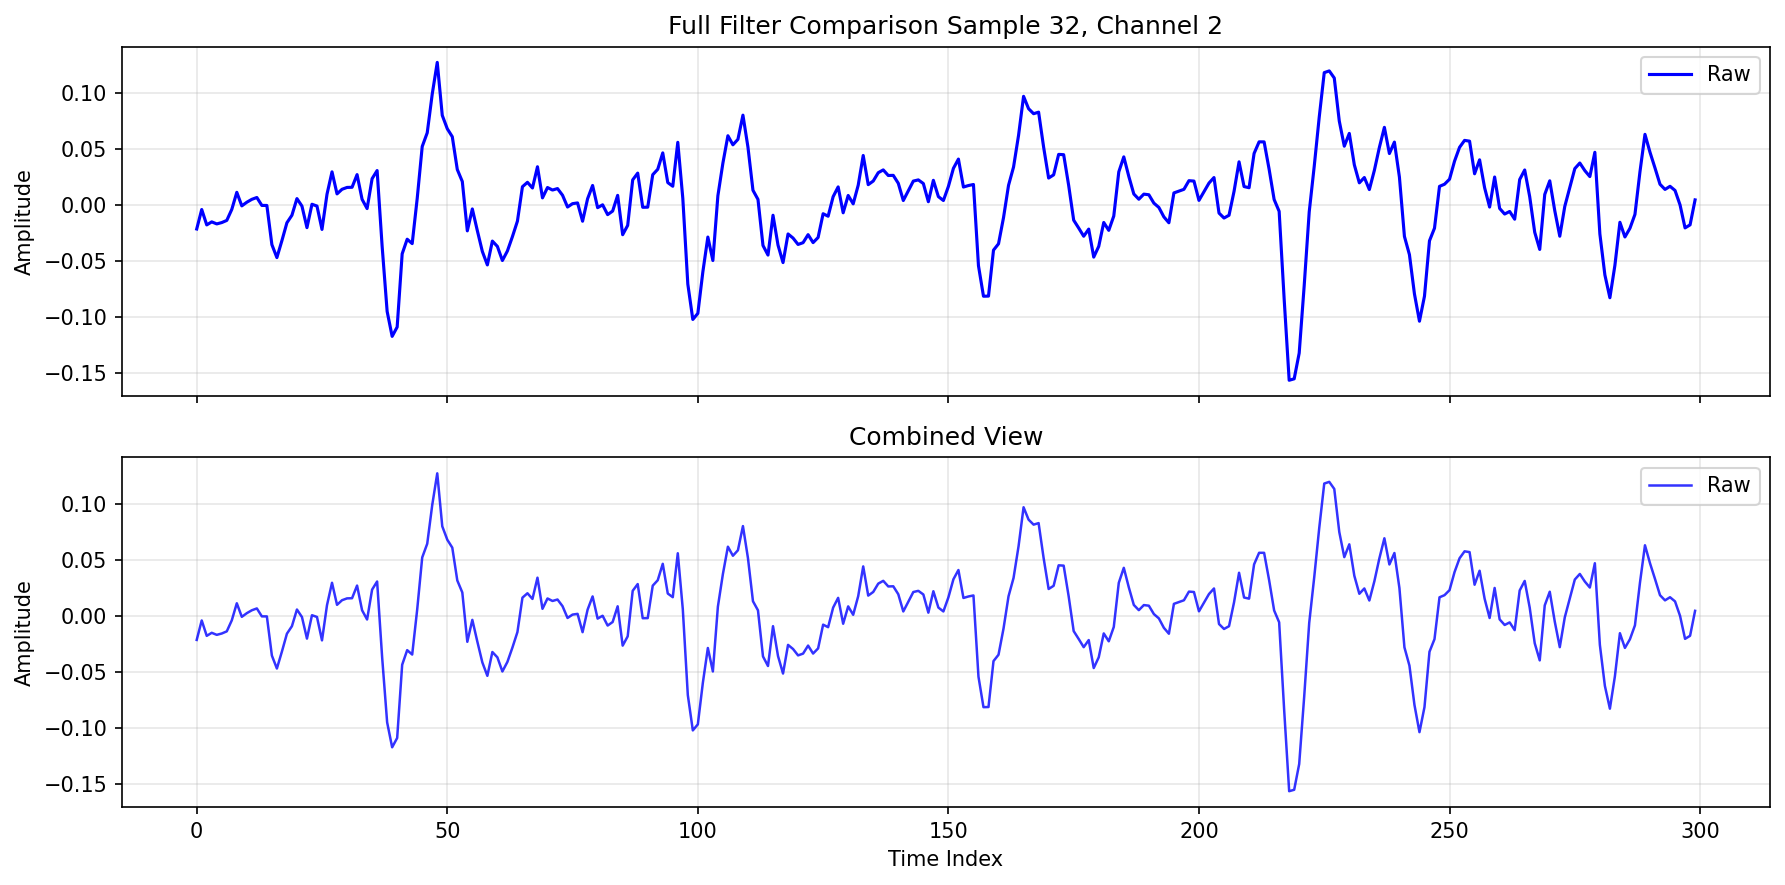

In [19]:
plot_signal_variants(
    X_raw=X_train_raw,
    # X_ma=X_train_ma,
    # X_ham=X_train_ham,
    # X_butter=X_train_butter,
    example_idx=32,    # Change this to see different samples
    channel_idx=2,    # Change this to see different sensors (accel_x, gyro_z, etc.)
    title_prefix="Full Filter Comparison"
)
#  28 32 60 266 388 440 441 471

In [20]:
USE_VARIANT = "raw"   # "ma", "ham", or "butter"

if USE_VARIANT == "raw":
    X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
elif USE_VARIANT == "ma":
    X_train, X_val, X_test = X_train_ma, X_val_ma, X_test_ma
elif USE_VARIANT == "ham":
    X_train, X_val, X_test = X_train_ham, X_val_ham, X_test_ham
elif USE_VARIANT == "butter":
    X_train, X_val, X_test = X_train_butter, X_val_butter, X_test_butter
else:
    raise ValueError("Unknown USE_VARIANT")


In [21]:
# Compute mean/std over training portion later if you prefer;
# here we just show how to normalize a 3D tensor (N, C, L):


# channel-wise z-scoring
def normalize_channels(X, mean=None, std=None):
    # X: (N, C, L) tensor
    if mean is None or std is None:
        mean = X.mean(dim=(0, 2), keepdim=True)
        std = X.std(dim=(0, 2), keepdim=True) + 1e-6
    X_norm = (X - mean) / std
    return X_norm, mean, std


In [22]:
# ------------------------
# Per‑channel normalization using train set only
# ------------------------

# --- enable/disable normalization here ---
USE_NORMALIZATION = False

if USE_NORMALIZATION:
    X_train, train_mean, train_std = normalize_channels(X_train)
    X_val,   _, _ = normalize_channels(X_val,   mean=train_mean, std=train_std)
    X_test,  _, _ = normalize_channels(X_test,  mean=train_mean, std=train_std)

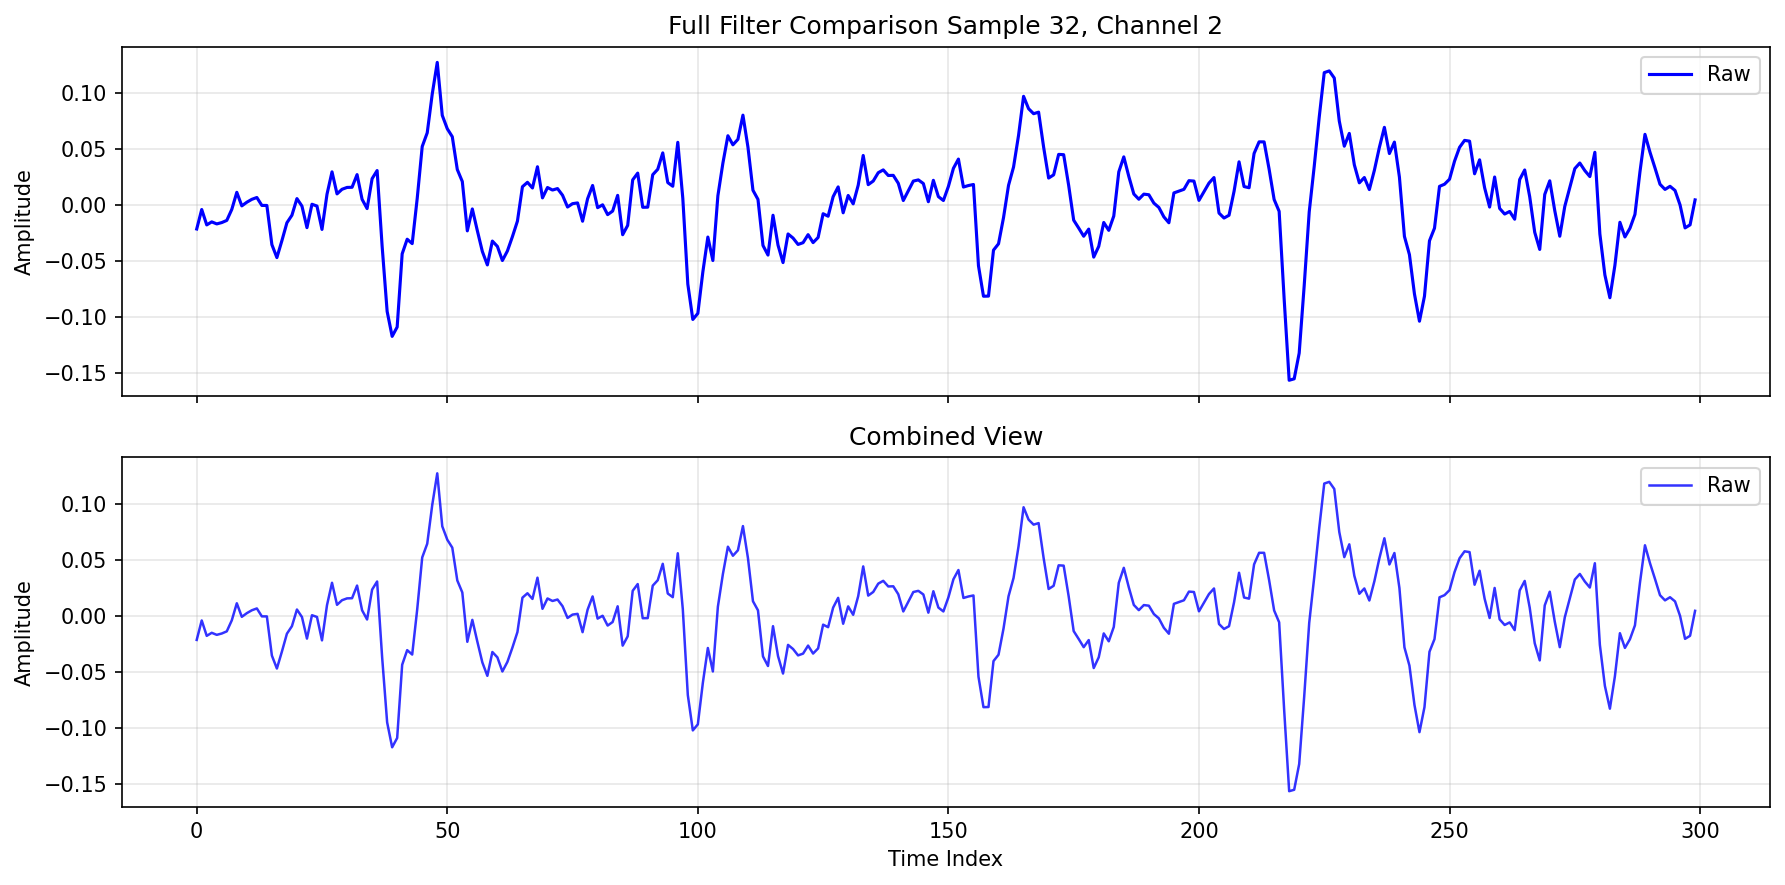

In [23]:
plot_signal_variants(
    X_raw=X_train,
    # X_ma=X_train_ma,
    # X_ham=X_train_ham,
    # X_butter=X_train_butter,
    example_idx=32,    # Change this to see different samples
    channel_idx=2,    # Change this to see different sensors (accel_x, gyro_z, etc.)
    title_prefix="Full Filter Comparison"
)

In [24]:
import torch

# ------------------------
# Scaling Configuration
# ------------------------
# Options: "none", "minmax", "fixed"
SCALING_METHOD = "none"  

# Target range for MinMax (Recommended: -1 to 1 for Deep Learning)
SCALING_RANGE = (-1.0, 1.0) 

# Hardware Limits for "fixed" scaling (KU-HAR approximate max values)
# Accel is usually +/- 2g or +/- 20 m/s^2
# Gyro is usually +/- 2000 dps or +/- 35 rad/s
FIXED_LIMIT_ACCEL = 20.0
FIXED_LIMIT_GYRO  = 35.0

# ------------------------
# Helper Functions
# ------------------------
def minmax_scale_channels(X, min_val=None, max_val=None, feature_range=(-1.0, 1.0)):
    """
    Global Per-channel Min-Max scaling.
    Calculates stats from 'X' if min_val/max_val are not provided.
    """
    low, high = feature_range
    
    # 1. Compute Global Stats (if needed)
    if min_val is None or max_val is None:
        # dim=(0, 2) collapses Batch(0) and Time(2), leaving one stat per Channel(1)
        min_val = X.amin(dim=(0, 2), keepdim=True)
        max_val = X.amax(dim=(0, 2), keepdim=True)
    
    # 2. Prevent Divide-by-Zero (Clamp denominator)
    denom = (max_val - min_val).clamp(min=1e-6)
    
    # 3. Scale to [0, 1] first
    X_scaled = (X - min_val) / denom
    
    # 4. Shift to [low, high]
    X_scaled = X_scaled * (high - low) + low
    
    return X_scaled, min_val, max_val

def fixed_scale_channels(X, limit_accel=20.0, limit_gyro=35.0):
    """
    Scales data based on known hardware limits.
    Assumes channels 0-2 are Accel, 3-5 are Gyro.
    Target range is approx [-1, 1].
    """
    # Clone to avoid in-place modification bugs
    X_out = X.clone()
    
    # Scale Accel (Channels 0, 1, 2)
    X_out[:, :3, :] /= limit_accel
    
    # Scale Gyro (Channels 3, 4, 5)
    # Check if we actually have gyro channels before scaling
    if X.shape[1] > 3:
        X_out[:, 3:, :] /= limit_gyro
        
    return X_out

# ------------------------
# Execution Block
# ------------------------

# 1. Create Clones (Crucial! Preserve original raw data)
X_train_scaled = X_train.clone()
X_val_scaled   = X_val.clone()
X_test_scaled  = X_test.clone()

# 2. Apply Scaling Strategy
if SCALING_METHOD == "minmax":
    print(f"Applying Global MinMax Scaling to range {SCALING_RANGE}...")
    
    # Calculate stats ONLY on Training set
    X_train_scaled, train_min, train_max = minmax_scale_channels(
        X_train_scaled, 
        feature_range=SCALING_RANGE
    )
    
    # Apply Training stats to Val/Test (Never re-compute on test!)
    X_val_scaled, _, _ = minmax_scale_channels(
        X_val_scaled, 
        min_val=train_min, 
        max_val=train_max, 
        feature_range=SCALING_RANGE
    )
    
    X_test_scaled, _, _ = minmax_scale_channels(
        X_test_scaled, 
        min_val=train_min, 
        max_val=train_max, 
        feature_range=SCALING_RANGE
    )

elif SCALING_METHOD == "fixed":
    print(f"Applying Fixed Hardware Scaling (Accel=/{FIXED_LIMIT_ACCEL}, Gyro=/{FIXED_LIMIT_GYRO})...")
    
    # Simple division, robust for all sets
    X_train_scaled = fixed_scale_channels(X_train_scaled, FIXED_LIMIT_ACCEL, FIXED_LIMIT_GYRO)
    X_val_scaled   = fixed_scale_channels(X_val_scaled,   FIXED_LIMIT_ACCEL, FIXED_LIMIT_GYRO)
    X_test_scaled  = fixed_scale_channels(X_test_scaled,  FIXED_LIMIT_ACCEL, FIXED_LIMIT_GYRO)

else:
    print("Skipping Scaling (Using Raw Data).")

# 3. Final Assignment (Overwrite the main variables for the model to use)
X_train = X_train_scaled
X_val   = X_val_scaled
X_test  = X_test_scaled

print("Scaling complete.")

Skipping Scaling (Using Raw Data).
Scaling complete.


In [25]:
# ------------------------
# Inspect train/val/test before training
# ------------------------

print("Train X:", X_train.shape, "y:", y_train.shape)
print("Val   X:", X_val.shape,   "y:", y_val.shape)
print("Test  X:", X_test.shape,  "y:", y_test.shape)

# Label distributions (class imbalance check)
print("Train label counts:", torch.bincount(y_train))
print("Val   label counts:", torch.bincount(y_val))
print("Test  label counts:", torch.bincount(y_test))

# Optional: per-channel mean/std on train after normalization
print("Train channel mean after norm:", X_train.mean(dim=(0, 2)))
print("Train channel std  after norm:", X_train.std(dim=(0, 2)))

# ------------------------
# Data augmentation for training only
# ------------------------

class KUHARDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]          # (C, L)
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y


class AddGaussianNoise:
    def __init__(self, std=0.01):
        self.std = std
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std

class RandomScaling:
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range
    def __call__(self, x):
        factor = torch.empty(1).uniform_(*self.scale_range).item()
        return x * factor

class RandomTimeJitter:
    def __init__(self, max_shift=5):
        self.max_shift = max_shift
    def __call__(self, x):
        # x: (C, L), roll along time axis
        shift = torch.randint(-self.max_shift, self.max_shift + 1, (1,)).item()
        return torch.roll(x, shifts=shift, dims=1)

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x

# Choose which augmentations to enable
USE_AUGMENTATION = False

if USE_AUGMENTATION:
    train_transform = Compose([
        AddGaussianNoise(std=0.02),     # tweak std
        RandomScaling(scale_range=(0.95, 1.05)),
        RandomTimeJitter(max_shift=5),
    ])
else:
    train_transform = None

train_ds = KUHARDataset(X_train, y_train, transform=train_transform)
val_ds   = KUHARDataset(X_val,   y_val,   transform=None)
test_ds  = KUHARDataset(X_test,  y_test,  transform=None)

# Class imbalance options
num_classes = n_classes
class_counts = torch.bincount(y_train, minlength=num_classes)  # (18,)
class_weights = 1.0 / (class_counts.float() + 1e-6)
class_weights = class_weights / class_weights.sum() * num_classes  # normalize (optional)

print("Class counts:", class_counts)
print("Class weights:", class_weights)


# “resampling” at the batch level / data level
# You usually use either class‑weighted loss, or sampler, or both; start with class‑weighted loss since it is simpler.
USE_WEIGHTED_SAMPLER = False  # set True to enable

if USE_WEIGHTED_SAMPLER:
    # weight per sample = weight of its class
    sample_weights = class_weights[y_train]  # (N_train,)
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_ds, batch_size=64, sampler=sampler)
else:
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

val_loader  = DataLoader(val_ds,  batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

Train X: torch.Size([14525, 6, 300]) y: torch.Size([14525])
Val   X: torch.Size([3112, 6, 300]) y: torch.Size([3112])
Test  X: torch.Size([3113, 6, 300]) y: torch.Size([3113])
Train label counts: tensor([1320, 1312, 1258, 1306, 1525, 1269, 1233,  933,  466,  336,  703,  617,
         222,  181,  417,  559,  547,  321])
Val   label counts: tensor([283, 281, 269, 280, 326, 272, 264, 200, 100,  72, 151, 132,  48,  39,
         89, 120, 117,  69])
Test  label counts: tensor([283, 281, 270, 280, 327, 272, 265, 200, 100,  72, 151, 133,  47,  39,
         89, 119, 117,  68])
Train channel mean after norm: tensor([ -49.6775,  120.6727, -240.9411,    0.9355,   71.6308,  131.2621])
Train channel std  after norm: tensor([4196.5405, 5117.5483, 5340.2236, 1342.3372, 2036.8246, 3046.1023])
Class counts: tensor([1320, 1312, 1258, 1306, 1525, 1269, 1233,  933,  466,  336,  703,  617,
         222,  181,  417,  559,  547,  321])
Class weights: tensor([0.4043, 0.4067, 0.4242, 0.4086, 0.3499, 0.4205, 0.4

# Models

In [26]:
class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=5, dilation=1, dropout=0.2):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation

        self.conv = nn.Conv1d(
            in_ch,
            out_ch,
            kernel_size=kernel_size,
            dilation=dilation
        )
        self.bn = nn.BatchNorm1d(out_ch)  # NEW
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # 1×1 conv for residual connection
        self.downsample = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else None

    def forward(self, x):
        # causal padding: (left_pad, right_pad) = (pad, 0)
        x_padded = F.pad(x, (self.pad, 0))

        out = self.conv(x_padded)
        out = self.bn(out)       # NEW
        out = self.relu(out)
        out = self.dropout(out)

        # residual
        res = x if self.downsample is None else self.downsample(x)
        return out + res


In [27]:
class KUHAR_TCN(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()

        # Dilations: 1 → 2 → 4
        self.tcn1 = TCNBlock(6,   32, kernel_size=5, dilation=1)
        self.tcn2 = TCNBlock(32,  64, kernel_size=5, dilation=2)
        self.tcn3 = TCNBlock(64, 128, kernel_size=5, dilation=4)

        # No pooling. Length stays 300.
        self.fc1 = nn.Linear(128 * 300, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):   
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = self.tcn3(x)

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TCNBlock_v2(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=5, dilation=1, dropout=0.2):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation

        # 1. Weight Norm is preferred over BatchNorm for TCNs usually, 
        # but if you use BN, keep it. 
        # We will add WeightNorm here for stability if you prefer, 
        # but let's stick to your structure with BN for now to minimize changes.
        self.conv = nn.Conv1d(
            in_ch, 
            out_ch, 
            kernel_size=kernel_size, 
            dilation=dilation
        )
        self.bn = nn.BatchNorm1d(out_ch) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Residual connection
        self.downsample = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else None

    def forward(self, x):
        x_padded = F.pad(x, (self.pad, 0)) # Causal padding
        out = self.conv(x_padded)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

class KUHAR_TCN_v2(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()

        self.tcn1 = TCNBlock_v2(6,  32, kernel_size=5, dilation=1)
        self.tcn2 = TCNBlock_v2(32, 64, kernel_size=5, dilation=2)
        self.tcn3 = TCNBlock_v2(64, 128, kernel_size=5, dilation=4)

        # CRITICAL CHANGE: Input to fc1 is now 128, not 128*300
        self.fc1 = nn.Linear(128, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):   
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = self.tcn3(x) # Shape: (Batch, 128, 300)

        # --- CRITICAL FIX: GLOBAL AVERAGE POOLING ---
        # Average over the time dimension (dim=2)
        # Turns (Batch, 128, 300) -> (Batch, 128)
        x = x.mean(dim=2) 
        
        # No reshape needed anymore
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [29]:
class KUHARNet(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2) #ks ---> HPO
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.pool  = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)

        # 300 -> 150 -> 75 -> 37 (integer division)
        self.fc1 = nn.Linear(128 * 37, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):        # x: (B, 6, 300)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # (B, 32, 150)
        # -----------------
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # (B, 64, 75)        
        # -----------------
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # (B, 128, 37)
        # -----------------
        # Flatten for Fully Connected Layers
        x = x.view(x.size(0), -1) # (B, 128, 37) -> (B, 128 x 37)
        # -----------------
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # -----------------
        x = self.fc2(x) # (B, 18)
        
        
        
        # x = self.pool(F.relu(self.conv1(x)))   # (B, 32, 150)
        # x = self.pool(F.relu(self.conv2(x)))   # (B, 64, 75)
        # x = self.pool(F.relu(self.conv3(x)))   # (B, 128, 37)
        # x = x.view(x.size(0), -1)
        # x = self.dropout(F.relu(self.fc1(x)))
        # x = self.fc2(x)
        return x

In [30]:
class KUHARNet_1_bn(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm1d(128)
        
        self.pool  = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # 300 -> 150 -> 75 -> 37 (integer division)
        self.fc1 = nn.Linear(128 * 37, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)        # (B, 32, 300)
        # x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)        # (B, 64, 150)
        # x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)        # (B, 128, 75)
        # x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)         # (B, 128, 37)

        # Flatten
        x = x.view(x.size(0), -1)  # (B, 128*37)

        # Dense head
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)            # (B, 18)

        return x

In [31]:
# --------- Causal Conv 1D ---------
class CausalConv1d(nn.Module):
    """
    1D causal convolution: output length == input length, no seeing the future.
    """
    def __init__(self, in_ch, out_ch, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_ch, out_ch,
            kernel_size=kernel_size,
            dilation=dilation
        )

    def forward(self, x):
        # x: (B, C, L)
        x = F.pad(x, (self.pad, 0))  # pad on left
        return self.conv(x)

# --------- One WaveNet-style residual block ---------
class WaveNetBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1, dropout=0.2):
        super().__init__()
        self.filter_conv = CausalConv1d(channels, channels, kernel_size, dilation)
        self.gate_conv   = CausalConv1d(channels, channels, kernel_size, dilation)

        self.dropout = nn.Dropout(dropout)
        self.residual_conv = nn.Conv1d(channels, channels, kernel_size=1)
        self.skip_conv     = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        # x: (B, C, L)
        # Gated activation unit
        filt = torch.tanh(self.filter_conv(x))
        gate = torch.sigmoid(self.gate_conv(x))
        z = filt * gate
        z = self.dropout(z)

        # Residual and skip
        residual = self.residual_conv(z) + x      # (B, C, L)
        skip     = self.skip_conv(z)              # (B, C, L)
        return residual, skip

# --------- WaveNet classifier for KUHAR ---------
class KUHAR_WaveNet(nn.Module):
    def __init__(self, n_classes=18,
                 in_channels=6,
                 channels=64,
                 kernel_size=3,
                 num_blocks=8,
                 dropout=0.2):
        super().__init__()

        # Initial 1x1 conv to project 6 -> channels
        self.input_conv = nn.Conv1d(in_channels, channels, kernel_size=1)

        # Stack of WaveNet blocks with exponentially increasing dilation
        blocks = []
        dilations = [2 ** i for i in range(num_blocks)]
        for d in dilations:
            blocks.append(
                WaveNetBlock(
                    channels=channels,
                    kernel_size=kernel_size,
                    dilation=d,
                    dropout=dropout
                )
            )
        self.blocks = nn.ModuleList(blocks)

        # Output head: aggregate skips -> global avg pool -> dense classifier
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, C, L) -> (B, C, 1)

        self.fc1 = nn.Linear(channels, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # x: (B, 6, 300)
        x = self.input_conv(x)     # (B, C, 300)
        skip_connections = []

        for block in self.blocks:
            x, skip = block(x)     # both (B, C, L)
            skip_connections.append(skip)

        # Sum all skip connections
        s = sum(skip_connections)  # (B, C, L)
        s = self.relu(s)

        # Global avg pool over time
        s = self.global_pool(s).squeeze(-1)  # (B, C)

        # Dense head
        s = self.fc1(s)
        s = self.relu(s)
        s = self.dropout(s)
        s = self.fc2(s)  # (B, n_classes)

        return s


In [32]:
class KUHARNet_1_tanh(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.gn1   = nn.GroupNorm(8, 32)   # 8 groups of 4 channels each
        # self.bn1   = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.gn2   = nn.GroupNorm(8, 64)   # 8 groups of 8 channels each
        # self.bn2   = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.gn3   = nn.GroupNorm(16, 128) # 16 groups of 8 channels each
        # self.bn3   = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.gn4   = nn.GroupNorm(16, 256) # 16 groups of 16 channels each
        # self.bn4   = nn.BatchNorm1d(256)
        
        self.pool  = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # 300 -> 150 -> 75 -> 37 -> 18(integer division)
        self.fc1 = nn.Linear(256 * 18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_classes)

        self.tanh = nn.Tanh()

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)        # (B, 32, 300)
        # x = self.bn1(x)
        x = self.gn1(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)        # (B, 64, 150)
        # x = self.bn2(x)
        x = self.gn2(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)        # (B, 128, 75)
        # x = self.bn3(x)
        x = self.gn3(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 128, 37)

        # Block 4
        x = self.conv4(x)        # (B, 256, 37)
        # x = self.bn4(x)
        x = self.gn4(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 256, 18)
        
        # Flatten
        x = x.view(x.size(0), -1)  # (B, 256*18)

        # Dense head
        x = self.fc1(x)            # (B, 256)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)            # (B, 128)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)            # (B, 18)

        return x

In [33]:

# Deeper Head only
class KUHARNet_1_tanh_v2(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.gn1   = nn.GroupNorm(8, 32)   # 8 groups of 4 channels each
        # self.bn1   = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.gn2   = nn.GroupNorm(8, 64)   # 8 groups of 8 channels each
        # self.bn2   = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.gn3   = nn.GroupNorm(16, 128) # 16 groups of 8 channels each
        # self.bn3   = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.gn4   = nn.GroupNorm(16, 256) # 16 groups of 16 channels each
        # self.bn4   = nn.BatchNorm1d(256)
        
        self.pool  = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # 300 -> 150 -> 75 -> 37 -> 18(integer division)
        self.fc1 = nn.Linear(256 * 18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_classes)

        self.tanh = nn.Tanh()

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)        # (B, 32, 300)
        # x = self.bn1(x)
        x = self.gn1(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)        # (B, 64, 150)
        # x = self.bn2(x)
        x = self.gn2(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)        # (B, 128, 75)
        # x = self.bn3(x)
        x = self.gn3(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 128, 37)

        # Block 4
        x = self.conv4(x)        # (B, 256, 37)
        # x = self.bn4(x)
        x = self.gn4(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 256, 18)
        
        # Flatten
        x = x.reshape(x.size(0), -1)  # (B, 256*18)

        # Dense head
        x = self.fc1(x)            # (B, 128)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)            # (B, 64)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)            # (B, 32)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)            # (B, 18)

        return x

In [34]:

# Deeper Head only + gelu
class KUHARNet_1_tanh_v3(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.gn1   = nn.GroupNorm(8, 32)   # 8 groups of 4 channels each
        # self.bn1   = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.gn2   = nn.GroupNorm(8, 64)   # 8 groups of 8 channels each
        # self.bn2   = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.gn3   = nn.GroupNorm(16, 128) # 16 groups of 8 channels each
        # self.bn3   = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.gn4   = nn.GroupNorm(16, 256) # 16 groups of 16 channels each
        # self.bn4   = nn.BatchNorm1d(256)
        
        self.pool  = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # 300 -> 150 -> 75 -> 37 -> 18(integer division)
        self.fc1 = nn.Linear(256 * 18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_classes)

        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)        # (B, 32, 300)
        # x = self.bn1(x)
        x = self.gn1(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)        # (B, 64, 150)
        # x = self.bn2(x)
        x = self.gn2(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)        # (B, 128, 75)
        # x = self.bn3(x)
        x = self.gn3(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 128, 37)

        # Block 4
        x = self.conv4(x)        # (B, 256, 37)
        # x = self.bn4(x)
        x = self.gn4(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 256, 18)
        
        # Flatten
        x = x.reshape(x.size(0), -1)  # (B, 256*18)

        # Dense head
        x = self.fc1(x)            # (B, 128)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)            # (B, 64)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)            # (B, 32)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc4(x)            # (B, 18)

        return x

In [35]:

# Deeper Head only + relu + AvgPool
class KUHARNet_1_tanh_v4(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.gn1   = nn.GroupNorm(8, 32)   # 8 groups of 4 channels each
        # self.bn1   = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.gn2   = nn.GroupNorm(8, 64)   # 8 groups of 8 channels each
        # self.bn2   = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.gn3   = nn.GroupNorm(16, 128) # 16 groups of 8 channels each
        # self.bn3   = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.gn4   = nn.GroupNorm(16, 256) # 16 groups of 16 channels each
        # self.bn4   = nn.BatchNorm1d(256)
        
        # self.pool  = nn.MaxPool1d(2)
        self.pool  = nn.AvgPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # 300 -> 150 -> 75 -> 37 -> 18(integer division)
        self.fc1 = nn.Linear(256 * 18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_classes)

        self.tanh = nn.Tanh()
        # self.gelu = nn.GELU()

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)        # (B, 32, 300)
        # x = self.bn1(x)
        x = self.gn1(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)        # (B, 64, 150)
        # x = self.bn2(x)
        x = self.gn2(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)        # (B, 128, 75)
        # x = self.bn3(x)
        x = self.gn3(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 128, 37)

        # Block 4
        x = self.conv4(x)        # (B, 256, 37)
        # x = self.bn4(x)
        x = self.gn4(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 256, 18)
        
        # Flatten
        x = x.reshape(x.size(0), -1)  # (B, 256*18)

        # Dense head
        x = self.fc1(x)            # (B, 128)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)            # (B, 64)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)            # (B, 32)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)            # (B, 18)

        return x

In [36]:
# Deeper Head only + relu + AvgPool + SPATIAL PYRAMID POOLING (SPP/AdaptiveAvgPool1d)
class KUHARNet_SPP(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        
        # --- BLOCKS 1-3 (Unchanged) ---
        self.conv1 = nn.Conv1d(6, 32, kernel_size=5, padding=2)
        self.gn1   = nn.GroupNorm(8, 32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.gn2   = nn.GroupNorm(8, 64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.gn3   = nn.GroupNorm(16, 128)
        
        # --- BLOCK 4 (Modified) ---
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.gn4   = nn.GroupNorm(16, 256)
        
        # Standard pool for early layers to reduce size
        self.pool  = nn.AvgPool1d(2) 
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

        # --- SPATIAL PYRAMID POOLING (SPP) SETUP ---
        # We will pool the final feature map into 3 fixed sizes: 1, 2, and 4.
        # Total bins = 1 + 2 + 4 = 7
        self.spp_pool_1 = nn.AdaptiveAvgPool1d(1)
        self.spp_pool_2 = nn.AdaptiveAvgPool1d(2)
        self.spp_pool_4 = nn.AdaptiveAvgPool1d(4)
        
        # Calculate new input size for FC1
        # 256 channels * (1 + 2 + 4) bins = 256 * 7 = 1792
        self.fc_input_dim = 256 * 7 

        # --- DENSE HEAD ---
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_classes)

    def forward(self, x):        # x: (B, 6, 300)
        # Block 1
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 32, 150)

        # Block 2
        x = self.conv2(x)
        x = self.gn2(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 64, 75)

        # Block 3
        x = self.conv3(x)
        x = self.gn3(x)
        x = self.tanh(x)
        x = self.pool(x)         # (B, 128, 37)

        # Block 4 (No final fixed pool here, we use SPP instead)
        x = self.conv4(x)
        x = self.gn4(x)
        x = self.tanh(x)         # (B, 256, 37)
        
        # --- APPLY SPATIAL PYRAMID POOLING ---
        # Branch 1: Global Average (B, 256, 1)
        out1 = self.spp_pool_1(x).flatten(start_dim=1)
        
        # Branch 2: Split in half (B, 256, 2)
        out2 = self.spp_pool_2(x).flatten(start_dim=1)
        
        # Branch 3: Split in four (B, 256, 4)
        out4 = self.spp_pool_4(x).flatten(start_dim=1)
        
        # Concatenate all features: (B, 256*1 + 256*2 + 256*4) = (B, 1792)
        x = torch.cat([out1, out2, out4], dim=1)

        # --- DENSE HEAD ---
        x = self.fc1(x)          
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)          
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)          
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)          
        return x

In [37]:
class EEGNetKUHAR(nn.Module):
    def __init__(self,
                 n_classes=18,
                 chans=6,
                 samples=300,
                 dropout_rate=0.5,
                 kern_length=64,   # temporal kernel length
                 F1=8,
                 D=2,
                 F2=None):
        super().__init__()
        if F2 is None:
            F2 = F1 * D  # as in EEGNet paper

        self.chans = chans
        self.samples = samples

        # --------------
        # Block 1: temporal conv + depthwise spatial conv
        # --------------

        # Conv2d over (time) with kernel (1, kern_length)
        # Input will be (B, 1, chans, samples)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=F1,
            kernel_size=(1, kern_length),
            padding=(0, kern_length // 2),
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(F1)

        # DepthwiseConv2D over channels: kernel (chans, 1), groups=F1
        self.depthwise = nn.Conv2d(
            in_channels=F1,
            out_channels=F1 * D,
            kernel_size=(chans, 1),
            groups=F1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(F1 * D)

        self.elu = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        # --------------
        # Block 2: separable conv (depthwise + pointwise)
        # --------------

        # Depthwise spatial-temporal conv over time axis
        self.separable_depth = nn.Conv2d(
            in_channels=F1 * D,
            out_channels=F1 * D,
            kernel_size=(1, 16),
            padding=(0, 16 // 2),
            groups=F1 * D,
            bias=False
        )
        # Pointwise conv to mix feature maps
        self.separable_point = nn.Conv2d(
            in_channels=F1 * D,
            out_channels=F2,
            kernel_size=(1, 1),
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(F2)

        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        # --------------
        # Classifier
        # --------------
        # After:
        # - Block1 pool: time dim /4
        # - Block2 pool: further /8
        # So time roughly: samples / (4*8) = samples / 32
        # For samples=300 -> ~9 or 10 steps
        # Spatial dim becomes 1 after depthwise conv (kernel size chans)
        # So feature map roughly: (B, F2, 1, T_out)

        # We can compute T_out dynamically in forward, or assume ~9–10
        # Safer: use AdaptiveAvgPool2d to collapse spatial and time dims
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(F2, n_classes)

    def forward(self, x):
        # x: (B, chans, samples) -> (B, 1, chans, samples)
        x = x.unsqueeze(1)

        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwise(x)
        x = self.bn2(x)
        x = self.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2 (separable conv)
        x = self.separable_depth(x)
        x = self.separable_point(x)
        x = self.bn3(x)
        x = self.elu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Global pooling and dense
        x = self.global_pool(x)          # (B, F2, 1, 1)
        x = x.view(x.size(0), -1)        # (B, F2)
        x = self.classifier(x)           # (B, n_classes)

        return x

In [38]:
class EEGNetKUHAR_GN(nn.Module):
    def __init__(self,
                 n_classes=18,
                 chans=6,
                 samples=300,
                 dropout_rate=0.5,
                 kern_length=64,   # temporal kernel length
                 F1=8,
                 D=2,
                 F2=None,
                 num_groups=4):     # groups for GroupNorm
        super().__init__()
        if F2 is None:
            F2 = F1 * D  # as in EEGNet paper

        self.chans = chans
        self.samples = samples

        # --------------
        # Block 1: temporal conv + depthwise spatial conv
        # --------------

        # Conv2d over time: (1, kern_length)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=F1,
            kernel_size=(1, kern_length),
            padding=(0, kern_length // 2),
            bias=False
        )
        self.gn1 = nn.GroupNorm(num_groups=num_groups, num_channels=F1)

        # DepthwiseConv2D over channels: kernel (chans, 1), groups=F1
        self.depthwise = nn.Conv2d(
            in_channels=F1,
            out_channels=F1 * D,
            kernel_size=(chans, 1),
            groups=F1,
            bias=False
        )
        self.gn2 = nn.GroupNorm(num_groups=num_groups, num_channels=F1 * D)

        self.elu = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        # --------------
        # Block 2: separable conv (depthwise + pointwise)
        # --------------

        self.separable_depth = nn.Conv2d(
            in_channels=F1 * D,
            out_channels=F1 * D,
            kernel_size=(1, 16),
            padding=(0, 16 // 2),
            groups=F1 * D,
            bias=False
        )
        self.separable_point = nn.Conv2d(
            in_channels=F1 * D,
            out_channels=F2,
            kernel_size=(1, 1),
            bias=False
        )
        self.gn3 = nn.GroupNorm(num_groups=num_groups, num_channels=F2)

        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        # --------------
        # Classifier
        # --------------
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(F2, n_classes)

    def forward(self, x):
        # x: (B, chans, samples) -> (B, 1, chans, samples)
        x = x.unsqueeze(1)

        # Block 1
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.depthwise(x)
        x = self.gn2(x)
        x = self.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.separable_depth(x)
        x = self.separable_point(x)
        x = self.gn3(x)
        x = self.elu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.global_pool(x).squeeze(-1).squeeze(-1)  # (B, F2)
        x = self.classifier(x)                           # (B, n_classes)
        return x

In [39]:
def channel_shuffle(x, groups):
    batchsize, num_channels, T = x.data.size()
    channels_per_group = num_channels // groups
    x = x.view(batchsize, groups, channels_per_group, T)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batchsize, -1, T)
    return x

def pool_per_T(T, L):
    if T >= 512:
        pool_num = 4
    elif T >= 256:
        pool_num = 3
    elif T >= 128:
        pool_num = 2
    elif T >= 64:
        pool_num = 1
    else:
        return []

    split = [int(np.floor(L / (pool_num + 1))) for _ in range(pool_num + 1)]
    residual = L - sum(split)
    for i in range(residual):
        split[i] += 1
    split.pop()

    pool_idx = []
    pidx = -1
    for i in split:
        pidx += i
        pool_idx.append(pidx)
    return pool_idx

class CALABlock(nn.Module):
    def __init__(self, i_nc, o_nc, L, T, pool):
        super().__init__()
        self.L = L
        self.pool = pool

        # Grouped Conv
        self.gconv = nn.Conv1d(
            i_nc, o_nc,
            kernel_size=5,
            padding="same",
            bias=False,
            groups=L
        )
        self.gn = nn.GroupNorm(num_groups=4, num_channels=o_nc)

        # LCTM-like temporal global conv
        self.tgconv = nn.Conv1d(o_nc, o_nc // L, kernel_size=T)

    def forward(self, x):
        _, _, t = x.size()
        if self.pool:
            x = F.adaptive_max_pool1d(x, t // 2)

        x = self.gconv(x)
        x = F.relu_(self.gn(x))

        l_feat = channel_shuffle(x, self.L)
        g_feat = F.relu_(self.tgconv(l_feat))
        return l_feat, g_feat

class CALANet(nn.Module):
    def __init__(self, nc_input, n_classes, segment_size, L):
        super().__init__()

        T = segment_size
        nc_o = 64
        if nc_input > 64:
            nc_o *= 2
            pre_mul = 1
        else:
            pre_mul = 0
        self.L = L

        self.stem = nn.Conv1d(nc_input, nc_o, 5, padding="same")
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        pool_idx = pool_per_T(T, L)

        T = math.ceil(T / 2)
        nc_i = nc_o

        out_channel_num = []
        self.layers = nn.ModuleList()

        for i in range(self.L):
            if i in pool_idx:
                pool = True
                T = T // 2
                if pre_mul > 0:
                    pre_mul -= 1
                else:
                    nc_o *= 2
            else:
                pool = False

            self.layers.append(CALABlock(nc_i, nc_o, self.L, T, pool))
            nc_i = nc_o
            out_channel_num.append(nc_o // L)

        self.fc = nn.Linear(sum(out_channel_num), n_classes)

    def forward(self, x):
        # x: (B, C, T)
        x = self.stem(x)
        x = self.maxpool(x)

        out = []
        for block in self.layers:
            x, g_feat = block(x)
            out.append(g_feat)

        out = torch.cat(out, dim=1)          # (B, sum(o_nc//L), 1)
        out = out.view(out.size(0), -1)      # (B, sum(out_channel_num))
        logits = self.fc(out)                # raw logits, no log_softmax
        return logits

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, nb_filters=32,
                 kernel_sizes=(9, 19, 39),
                 bottleneck_channels=32,
                 gn_groups=4):
        """
        One Inception module as in InceptionTime, with GroupNorm instead of BatchNorm.

        in_channels: input channels
        nb_filters: filters per branch
        kernel_sizes: tuple of kernel sizes (odd, for 'same' padding)
        bottleneck_channels: channels for 1x1 bottleneck (if in_channels > 1)
        gn_groups: number of groups for GroupNorm applied to the concatenated output
                   - Must divide total_channels = nb_filters * (len(kernel_sizes) + 1)
                   - E.g. nb_filters=32, 3 kernels -> total_channels = 32*4 = 128
                     so gn_groups can be 4, 8, 16, or 32
        """
        super().__init__()

        # 1x1 bottleneck
        if in_channels > 1:
            self.bottleneck = nn.Conv1d(
                in_channels, bottleneck_channels, kernel_size=1, bias=False
            )
            conv_in_channels = bottleneck_channels
        else:
            self.bottleneck = None
            conv_in_channels = in_channels

        # Three parallel conv branches with different kernel sizes
        self.conv_branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = k // 2
            self.conv_branches.append(
                nn.Conv1d(
                    conv_in_channels,
                    nb_filters,
                    kernel_size=k,
                    padding=padding,
                    bias=False,
                )
            )

        # MaxPool + 1x1 conv branch
        self.maxpool_branch = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, nb_filters, kernel_size=1, bias=False),
        )

        total_channels = nb_filters * (len(kernel_sizes) + 1)

        # GroupNorm instead of BatchNorm
        # Choose gn_groups so that gn_groups divides total_channels
        # Default gn_groups=4 works for nb_filters=32, kernel_sizes=(9,19,39):
        # total_channels = 32 * 4 = 128, 128 % 4 == 0
        self.gn = nn.GroupNorm(num_groups=gn_groups, num_channels=total_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, C, T)
        if self.bottleneck is not None:
            x_bottleneck = self.bottleneck(x)
        else:
            x_bottleneck = x

        out_branches = []
        for conv in self.conv_branches:
            out_branches.append(conv(x_bottleneck))

        out_branches.append(self.maxpool_branch(x))

        x_out = torch.cat(out_branches, dim=1)
        x_out = self.gn(x_out)
        x_out = self.relu(x_out)
        return x_out


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, nb_filters=32,
                 kernel_sizes=(9, 19, 39),
                 bottleneck_channels=32,
                 use_residual=True,
                 gn_groups=4):
        """
        One InceptionTime block: 3 InceptionModules + optional residual connection.
        """
        super().__init__()
        self.use_residual = use_residual

        total_channels = nb_filters * (len(kernel_sizes) + 1)

        self.inception1 = InceptionModule(
            in_channels=in_channels,
            nb_filters=nb_filters,
            kernel_sizes=kernel_sizes,
            bottleneck_channels=bottleneck_channels,
            gn_groups=gn_groups,
        )
        self.inception2 = InceptionModule(
            in_channels=total_channels,
            nb_filters=nb_filters,
            kernel_sizes=kernel_sizes,
            bottleneck_channels=bottleneck_channels,
            gn_groups=gn_groups,
        )
        self.inception3 = InceptionModule(
            in_channels=total_channels,
            nb_filters=nb_filters,
            kernel_sizes=kernel_sizes,
            bottleneck_channels=bottleneck_channels,
            gn_groups=gn_groups,
        )

        if self.use_residual:
            # Residual path: 1x1 conv + GroupNorm
            self.residual_conv = nn.Conv1d(
                in_channels,
                total_channels,
                kernel_size=1,
                bias=False,
            )
            self.residual_gn = nn.GroupNorm(
                num_groups=gn_groups,
                num_channels=total_channels,
            )
            self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, C, T)
        input_res = x

        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)

        if self.use_residual:
            res = self.residual_conv(input_res)
            res = self.residual_gn(res)
            x = self.relu(x + res)

        return x


class InceptionTimeKUHAR_GN(nn.Module):
    def __init__(self,
                 n_classes=18,
                 input_channels=6,
                 nb_filters=32,
                 depth=3,
                 kernel_sizes=(9, 19, 39),
                 bottleneck_channels=32,
                 use_residual=True,
                 gn_groups=4):
        """
        InceptionTime classifier adapted to KU-HAR with GroupNorm:

        - input: (B, 6, 300)
        - feature extractor: stack of InceptionBlocks
        - global average pooling over time
        - dense layer to n_classes

        gn_groups:
            - GroupNorm groups; must divide the number of channels in each block
            - For nb_filters=32 and 3 kernels, total_channels per block = 32 * 4 = 128
              so gn_groups can be 4, 8, 16, or 32.
            - 4 is a safe default for small to medium channel counts.
        """
        super().__init__()

        blocks = []
        in_channels = input_channels
        for _ in range(depth):
            block = InceptionBlock(
                in_channels=in_channels,
                nb_filters=nb_filters,
                kernel_sizes=kernel_sizes,
                bottleneck_channels=bottleneck_channels,
                use_residual=use_residual,
                gn_groups=gn_groups,
            )
            blocks.append(block)
            in_channels = nb_filters * (len(kernel_sizes) + 1)

        self.feature_extractor = nn.Sequential(*blocks)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(in_channels, n_classes)

    def forward(self, x):
        # x: (B, 6, 300)
        x = self.feature_extractor(x)              # (B, C_out, T)
        x = self.global_avg_pool(x).squeeze(-1)    # (B, C_out)
        x = self.fc(x)                             # (B, n_classes)
        return x


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepConvLSTM_KUHAR(nn.Module):
    def __init__(
        self,
        n_classes=18,
        input_channels=6,
        seq_len=300,
        conv_channels=64,
        conv_layers=4,
        kernel_size=5,
        lstm_hidden_size=128,
        lstm_layers=2,
        dropout=0.5,
        use_bidirectional=False,
    ):
        """
        DeepConvLSTM adapted for KU-HAR (6 x 300):

        - Several Conv1d layers over time: (B, C_in, T) -> (B, C_conv, T)
        - Reshape to (B, T, C_conv) for LSTM
        - Stacked LSTMs over time
        - Use last time step (or both directions if bidirectional) for classification
        """

        super().__init__()
        self.seq_len = seq_len
        self.use_bidirectional = use_bidirectional

        # --------- Convolutional feature extractor ---------
        convs = []
        in_ch = input_channels
        for i in range(conv_layers):
            convs.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=in_ch,
                        out_channels=conv_channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,
                        bias=False,
                    ),
                    nn.BatchNorm1d(conv_channels),
                    nn.ReLU(),
                )
            )
            in_ch = conv_channels

        self.conv_net = nn.Sequential(*convs)

        # --------- LSTM over temporal dimension ---------
        lstm_input_size = conv_channels
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=use_bidirectional,
        )

        # --------- Classifier head ---------
        if use_bidirectional:
            fc_input_size = lstm_hidden_size * 2
        else:
            fc_input_size = lstm_hidden_size

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input_size, n_classes)

    def forward(self, x):
        # x: (B, C, T) = (B, 6, 300)
        # 1) CNN over time
        x = self.conv_net(x)         # (B, conv_channels, T)

        # 2) Prepare for LSTM: (B, T, C)
        x = x.permute(0, 2, 1)       # (B, T, C_conv)

        # 3) LSTM over temporal dimension
        # lstm_out: (B, T, H_lstm * num_directions)
        lstm_out, _ = self.lstm(x)

        # 4) Use last time step representation
        last_out = lstm_out[:, -1, :]    # (B, H_lstm * num_directions)

        # 5) Classifier
        last_out = self.dropout(last_out)
        logits = self.fc(last_out)       # (B, n_classes)

        return logits


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepConvLSTM_KUHAR_GN(nn.Module):
    def __init__(
        self,
        n_classes=18,
        input_channels=6,
        seq_len=300,
        conv_channels=64,
        conv_layers=4,
        kernel_size=5,
        lstm_hidden_size=128,
        lstm_layers=2,
        dropout=0.5,
        use_bidirectional=False,
        gn_groups=4,
    ):
        """
        DeepConvLSTM adapted for KU-HAR (6 x 300) with GroupNorm:

        - Conv1d stack over time: (B, C_in, T) -> (B, conv_channels, T)
        - GroupNorm after each conv (no dependence on batch statistics)
        - Reshape to (B, T, C) and feed to stacked LSTMs
        - Use last time step for classification
        """

        super().__init__()
        self.seq_len = seq_len
        self.use_bidirectional = use_bidirectional

        # ------------- Convolutional feature extractor -------------
        convs = []
        in_ch = input_channels
        for i in range(conv_layers):
            convs.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=in_ch,
                        out_channels=conv_channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,
                        bias=False,
                    ),
                    # GroupNorm:
                    # - num_groups must divide conv_channels
                    # - conv_channels=64 -> gn_groups can be 4, 8, 16, or 32
                    nn.GroupNorm(num_groups=gn_groups, num_channels=conv_channels),
                    nn.ReLU(),
                )
            )
            in_ch = conv_channels

        self.conv_net = nn.Sequential(*convs)

        # ------------- LSTM over temporal dimension -------------
        lstm_input_size = conv_channels
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=use_bidirectional,
        )

        # ------------- Classifier head -------------
        if use_bidirectional:
            fc_input_size = lstm_hidden_size * 2
        else:
            fc_input_size = lstm_hidden_size

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input_size, n_classes)

    def forward(self, x):
        # x: (B, C, T) = (B, 6, 300)

        # 1) CNN over time
        x = self.conv_net(x)         # (B, conv_channels, T)

        # 2) Prepare for LSTM: (B, T, C)
        x = x.permute(0, 2, 1)       # (B, T, conv_channels)

        # 3) LSTM over temporal dimension
        lstm_out, _ = self.lstm(x)   # (B, T, H * num_directions)

        # 4) Use last time step
        last_out = lstm_out[:, -1, :]    # (B, H * num_directions)

        # 5) Classifier
        last_out = self.dropout(last_out)
        logits = self.fc(last_out)       # (B, n_classes)

        return logits


In [43]:
class ModBlock(nn.Module):
#class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=5, dilation=1, dropout=0.2):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation

        # Causal Conv1d
        self.conv = nn.Conv1d(
            in_ch,
            out_ch,
            kernel_size=kernel_size,
            dilation=dilation
        )

        # Modern: LayerNorm (normalized over channels)
        # LayerNorm expects normalized_shape = out_ch
        self.ln = nn.LayerNorm(out_ch)

        # Modern: GELU activation
        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(dropout)

        # Residual 1x1 conv (only when channels change)
        self.downsample = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else None

    def forward(self, x):
        # causal padding: (left_pad, right_pad) = (pad, 0)
        x_padded = F.pad(x, (self.pad, 0))

        out = self.conv(x_padded)

        # LayerNorm expects (N, L, C), but Conv1d outputs (N, C, L)
        out = out.transpose(1, 2)     # (N, C, L) → (N, L, C)
        out = self.ln(out)
        out = out.transpose(1, 2)     # (N, L, C) → (N, C, L)

        out = self.gelu(out)
        out = self.dropout(out)

        # residual
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class KUHAR_MOD(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()

        # Dilations: 1 → 2 → 4
        self.tcn1 = ModBlock(6,   32, kernel_size=5, dilation=1)
        self.tcn2 = ModBlock(32,  64, kernel_size=5, dilation=2)
        self.tcn3 = ModBlock(64, 128, kernel_size=5, dilation=4)

        # Fully connected classifier
        # No pooling, so flatten full sequence (assuming input length = 300)
        self.fc1 = nn.Linear(128 * 300, 128)
        self.gelu = nn.GELU()          # modern activation
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):   
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = self.tcn3(x)

        # Flatten
        x = x.reshape(x.size(0), -1)

        # Modern sequence for FC
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Utilities

In [44]:
def train_one_epoch(loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []    
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)             # 1st
        loss = criterion(out, yb)   # 2nd
        loss.backward()             # 3rd
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()            # 4th

        total_loss += loss.item() * yb.size(0)
        
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

    all_preds  = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    train_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    
    return total_loss / total, correct / total, train_f1

def eval_epoch(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []    
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)

            total_loss += loss.item() * yb.size(0)
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    # concatenate everything
    all_preds  = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")    
    
    return total_loss / total, correct / total, val_f1


In [45]:
def train_one_epoch_k(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []     
    
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        
        out = model(Xb)
        loss = criterion(out, yb)  # Uses the weighted/unweighted criterion passed in
        loss.backward()
        
        # Gradient clipping prevents exploding gradients in deep networks
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

    all_preds  = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Calculate Macro F1 for training monitoring
    train_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    
    return total_loss / total, correct / total, train_f1


def eval_one_epoch_k(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []     

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            
            out = model(Xb)
            loss = criterion(out, yb)

            total_loss += loss.item() * yb.size(0)
            
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds  = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")     
    
    return total_loss / total, correct / total, val_f1

## Model Selection

In [46]:
# ---------------------------------------------------
# CONFIG — MODEL SELECTION
# ---------------------------------------------------

# Instantiate the model dynamically
n_classes=18
# ------------------------------------------------------------------------------
# model = KUHAR_TCN(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHAR_TCN_v2(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet_1_bn(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet_1_tanh(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet_1_tanh_v2(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet_1_tanh_v3(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHARNet_1_tanh_v4(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
model = KUHARNet_SPP(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = KUHAR_WaveNet(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# model = EEGNetKUHAR(
#     n_classes=18,
#     chans=6,
#     samples=300,
#     dropout_rate=0.5,
#     kern_length=64,  # you can tune: 32, 64, 96
#     F1=8,
#     D=2
# ).to(device)
# ------------------------------------------------------------------------------
# model = EEGNetKUHAR_GN(
#     n_classes=18,
#     chans=6,
#     samples=300,
#     dropout_rate=0.5,
#     kern_length=64,
#     F1=8,
#     D=2,
#     num_groups=4  # or 2, 8, etc. as long as it divides F1, F1*D, F2
# ).to(device)
# ------------------------------------------------------------------------------
# n_classes = 18
# segment_size = 300
# input_nc = 6
# L = 8   # same as paper, or tune

# model = CALANet(
#     nc_input=input_nc,
#     n_classes=n_classes,
#     segment_size=segment_size,
#     L=L
# ).to(device)
# ------------------------------------------------------------------------------
# model = InceptionTimeKUHAR_GN(
#     n_classes=18,
#     input_channels=6,
#     nb_filters=32,
#     depth=3,
#     kernel_sizes=(9, 19, 39),
#     bottleneck_channels=32,
#     use_residual=True,
#     gn_groups=4   # or 8 if you increase nb_filters later and want more groups
# ).to(device)
# ------------------------------------------------------------------------------
# model = DeepConvLSTM_KUHAR(
#     n_classes=18,
#     input_channels=6,
#     seq_len=300,
#     conv_channels=64,   # can tune 32/64/128
#     conv_layers=4,      # typical DeepConvLSTM uses 4 conv layers
#     kernel_size=5,
#     lstm_hidden_size=128,
#     lstm_layers=2,
#     dropout=0.5,
#     use_bidirectional=False,  # True if you want BiLSTM
# ).to(device)
# ------------------------------------------------------------------------------
# model = DeepConvLSTM_KUHAR_GN(
#     n_classes=18,
#     input_channels=6,
#     seq_len=300,
#     conv_channels=64,
#     conv_layers=4,
#     kernel_size=5,
#     lstm_hidden_size=128,
#     lstm_layers=2,
#     dropout=0.5,
#     use_bidirectional=True,
#     gn_groups=4,   # 4 groups -> 64 / 4 = 16 channels per group
# ).to(device)
# ------------------------------------------------------------------------------
# model = KUHAR_MOD(n_classes=n_classes).to(device)
# ------------------------------------------------------------------------------
# 2) (Optional) compute FLOPs ONCE here
# from thop import profile

# dummy = torch.randn(1, 6, 300).to(device)
# flops, params = profile(model, inputs=(dummy,))
# print(f"Model FLOPs: {flops/1e6:.2f}M, Params: {params/1e6:.2f}M")


# ------------------------
# Optimizer
# ------------------------
# Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# CalaNet
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1,      # Cut LR by 10x
    patience=5,      # Wait 5 epochs before cutting
    verbose=True
)
# # Basic SGD (no momentum)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# # SGD with momentum
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.01,
#     momentum=0.9
# )

# # SGD with momentum + weight decay (L2 regularization)
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.01,
#     momentum=0.9,
#     weight_decay=1e-4
# )

# ------------------------
# Loss/Objective Function
# ------------------------

# Class‑weighted CrossEntropyLoss (cost‑sensitive)
# How much each sample’s error contributes to the loss and gradients
USE_CLASS_WEIGHTS = True

# Standard smoothing value is 0.1 (aims for 90% confidence instead of 100%)
LABEL_SMOOTHING_FACTOR = 0.1 

if USE_CLASS_WEIGHTS:
    weight_tensor = class_weights.to(device)
    # Apply both Class Weights AND Label Smoothing
    criterion = nn.CrossEntropyLoss(
        weight=weight_tensor, 
        label_smoothing=LABEL_SMOOTHING_FACTOR
    )
else:
    # Apply just Label Smoothing
    criterion = nn.CrossEntropyLoss(
        label_smoothing=LABEL_SMOOTHING_FACTOR
    )

print(model)
MODEL_NAME = model.__class__.__name__   # auto-detect: KUHARNet, KUHAR_TCN, etc.
print(MODEL_NAME)

KUHARNet_SPP(
  (conv1): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (gn1): GroupNorm(8, 32, eps=1e-05, affine=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (gn2): GroupNorm(8, 64, eps=1e-05, affine=True)
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (gn3): GroupNorm(16, 128, eps=1e-05, affine=True)
  (conv4): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (gn4): GroupNorm(16, 256, eps=1e-05, affine=True)
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
  (spp_pool_1): AdaptiveAvgPool1d(output_size=1)
  (spp_pool_2): AdaptiveAvgPool1d(output_size=2)
  (spp_pool_4): AdaptiveAvgPool1d(output_size=4)
  (fc1): Linear(in_features=1792, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_feat

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [47]:
# ------------------------------------------
# Model registry (add new models here once)
# ------------------------------------------
def get_model_by_name(name, **kwargs):
    """
    Instantiate a model class by its string name.
    Example: name="KUHARNet" or name="KUHAR_TCN"

    kwargs are passed to the model's constructor, e.g. n_classes=18.
    """
    try:
        model_class = globals()[name]   # look up model class in notebook globals()
    except KeyError:
        raise ValueError(f"Model class '{name}' not found. Make sure it is defined.")

    return model_class(**kwargs)


MODEL_CONFIGS = {
    "KUHARNet": dict(n_classes=18),
    "KUHAR_TCN": dict(n_classes=18),
    "KUHARNet_1_tanh": dict(n_classes=18),
    "KUHARNet_1_tanh_v2": dict(n_classes=18),
    "KUHARNet_1_tanh_v3": dict(n_classes=18),
    "KUHARNet_1_tanh_v4": dict(n_classes=18),
    "KUHARNet_SPP": dict(n_classes=18),
    "KUHARNet_1_bn": dict(n_classes=18),
    "KUHAR_WaveNet": dict(n_classes=18),
    "EEGNetKUHAR"
    "EEGNetKUHAR_GN": dict(n_classes=18, chans=6, samples=300),
    "CALANet": dict(nc_input=6, n_classes=18, segment_size=300, L=8),
    "InceptionTimeKUHAR_GN": dict(n_classes=18, input_channels = 6, nb_filters=32, depth=3, kernel_sizes=(9, 19, 39), bottleneck_channels=32, use_residual=True, gn_groups=4),
    "DeepConvLSTM_KUHAR": dict(n_classes=18, input_channels=6, seq_len=300, conv_channels=64, conv_layers=4, kernel_size=5, lstm_hidden_size=128, lstm_layers=2, dropout=0.3, use_bidirectional=False),
    "DeepConvLSTM_KUHAR_GN": dict(n_classes=18, input_channels=6, seq_len=300, conv_channels=64, conv_layers=4, kernel_size=5, lstm_hidden_size=128, lstm_layers=2, dropout=0.3, use_bidirectional=True, gn_groups=4),
    "KUHAR_MOD": dict(n_classes=18),
    # add others here as needed
}

# K-Fold Cross Validation

In [48]:
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import KFold, train_test_split
# from sklearn.utils import class_weight
# import copy
# import os
# import matplotlib.pyplot as plt
# import math

# # -----------------------------
# # 1. CONFIGURATION
# # -----------------------------
# EPOCHS = 40
# EARLY_STP = True      # Enable early stopping
# BATCH_SIZE = 64
# K_FOLDS = 5
# SEED = 42

# # --- NEW FLAG ---
# USE_COST_SENSITIVE_LOSS = True  # Set True to handle class imbalance dynamically

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # -----------------------------
# # 2. DATA PREPARATION
# # -----------------------------
# print("\nPreparing Data for K-Fold CV...")

# # Assuming 'X' and 'y' are your full dataset loaded in memory
# # They can be numpy arrays or tensors at this stage.

# # A. Create the Split (85% Train+Val for CV, 15% Hold-out Test)
# X_cv, X_test_holdout, y_cv, y_test_holdout = train_test_split(
#     X, y, 
#     test_size=3113,   # Exact number you requested
#     stratify=y,       # Ensures classes are balanced
#     random_state=SEED
# )

# # B. Convert to PyTorch Tensors
# #    We use torch.as_tensor to prevent the "int object not callable" error 
# #    and ensure efficient memory usage.
# X_tensor = torch.as_tensor(X_cv, dtype=torch.float32)
# y_tensor = torch.as_tensor(y_cv, dtype=torch.long)

# X_test_tensor = torch.as_tensor(X_test_holdout, dtype=torch.float32)
# y_test_tensor = torch.as_tensor(y_test_holdout, dtype=torch.long)

# # Ensure data is on CPU for splitting (prevents GPU memory fragmentation)
# X_tensor = X_tensor.cpu()
# y_tensor = y_tensor.cpu()
# X_test_tensor = X_test_tensor.cpu()
# y_test_tensor = y_test_tensor.cpu()

# print(f"  -> CV Training Data:   {X_tensor.shape} (Raw)")
# print(f"  -> Hold-out Test Data: {X_test_tensor.shape} (Raw)")

# # C. Create Test Loader (Fixed for all evaluations)
# test_loader = DataLoader(
#     TensorDataset(X_test_tensor, y_test_tensor),
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

# # -------------------------
# # 3. UTILITIES
# # -------------------------
# class EarlyStopping:
#     """
#     Stops training if validation metric doesn't improve after 'patience' epochs.
#     """
#     def __init__(self, mode='min', patience=10, min_delta=1e-4):
#         assert mode in ['min', 'max']
#         self.mode = mode
#         self.patience = patience
#         self.min_delta = min_delta
#         self.best = float('inf') if mode == 'min' else -float('inf')
#         self.num_bad_epochs = 0
#         self.should_stop = False

#     def step(self, current):
#         if self.mode == 'min':
#             if current < self.best - self.min_delta:
#                 self.best = current
#                 self.num_bad_epochs = 0
#             else:
#                 self.num_bad_epochs += 1
#         else:
#             if current > self.best + self.min_delta:
#                 self.best = current
#                 self.num_bad_epochs = 0
#             else:
#                 self.num_bad_epochs += 1

#         if self.num_bad_epochs >= self.patience:
#             self.should_stop = True
#         return self.should_stop

# # -----------------------------
# # 4. K-FOLD LOOP
# # -----------------------------
# kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# # Metrics Storage
# fold_results = {
#     "val_f1": [],
#     "val_acc": [],
#     "test_f1": [],
#     "test_acc": [],
#     "best_epoch": []
# }

# # Storage for full training history (losses/acc per epoch) for plotting
# all_folds_history = []

# # --- CONFIGURATION FOR THIS RUN ---
# LABEL_SMOOTHING_FACTOR = 0.1 
# LR_START = 1e-3  # Starting LR (Scheduler will decrease it)

# print(f"\nStarting {K_FOLDS}-Fold Cross Validation...")
# print(f"  [Config] Cost-Sensitive: {USE_COST_SENSITIVE_LOSS}")
# print(f"  [Config] Label Smoothing: {LABEL_SMOOTHING_FACTOR}")
# print(f"  [Config] Scheduler: ReduceLROnPlateau")

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    
#     print(f"\n==============================================")
#     print(f" FOLD {fold+1}/{K_FOLDS}")
#     print(f"==============================================")

#     # --- 4.1. Split Data for this Fold ---
#     X_train_fold = X_tensor[train_idx]
#     y_train_fold = y_tensor[train_idx]
#     X_val_fold   = X_tensor[val_idx]
#     y_val_fold   = y_tensor[val_idx]

#     # --- 4.2. Create DataLoaders ---
#     train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=BATCH_SIZE, shuffle=True)
#     val_loader   = DataLoader(TensorDataset(X_val_fold, y_val_fold),   batch_size=BATCH_SIZE, shuffle=False)

#     # --- 4.3. Re-Initialize Model & Optimizer ---
#     model = get_model_by_name(MODEL_NAME, n_classes=n_classes).to(device)
    
#     # Optimizer (Reset for every fold)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR_START)

#     # --- NEW: Scheduler (Reset for every fold) ---
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, 
#         mode='min',      # We want to minimize Loss
#         factor=0.1,      # Reduce LR by 10x
#         patience=5,      # Wait 5 epochs
#         verbose=True
#     )

#     # --- 4.4. Initialize Loss Function (Weighted + Smoothed) ---
#     if USE_COST_SENSITIVE_LOSS:
#         # Calculate weights based on THIS fold's training data
#         fold_classes = np.unique(y_train_fold.numpy())
#         class_weights = class_weight.compute_class_weight(
#             class_weight='balanced',
#             classes=fold_classes,
#             y=y_train_fold.numpy()
#         )
#         weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        
#         # Combined: Weights + Label Smoothing
#         criterion = nn.CrossEntropyLoss(
#             weight=weight_tensor, 
#             label_smoothing=LABEL_SMOOTHING_FACTOR
#         )
#     else:
#         # Just Label Smoothing
#         criterion = nn.CrossEntropyLoss(
#             label_smoothing=LABEL_SMOOTHING_FACTOR
#         )

#     # --- 4.5. Initialize Trackers ---
#     train_losses, val_losses = [], []
#     train_accs, val_accs     = [], []
#     train_f1s, val_f1s       = [], []

#     val_loss_stopper = EarlyStopping(mode='min', patience=15)
#     # val_acc_stopper  = EarlyStopping(mode='max', patience=10)
#     # val_f1_stopper   = EarlyStopping(mode='max', patience=10)

#     best_val_f1 = 0.0
#     best_val_acc = 0.0
#     best_fold_path = f"best_model_fold_{fold+1}.pt"

#     # --- 4.6. Training Loop ---
#     for epoch in range(EPOCHS):

#         # Train & Evaluate using your custom _k functions
#         # Passing 'criterion' is crucial here for the weighted loss to work
#         tr_loss, tr_acc, tr_f1 = train_one_epoch_k(model, train_loader, optimizer, criterion)
#         va_loss, va_acc, va_f1 = eval_one_epoch_k(model, val_loader, criterion)

#         # --- NEW: Step the Scheduler ---
#         # The scheduler watches Validation Loss
#         scheduler.step(va_loss)
        
#         # Store Metrics
#         train_losses.append(tr_loss)
#         val_losses.append(va_loss)
#         train_accs.append(tr_acc)
#         val_accs.append(va_acc)
#         train_f1s.append(tr_f1)
#         val_f1s.append(va_f1)

#         # Check Early Stopping
#         stop_on_loss = val_loss_stopper.step(va_loss)
#         # stop_on_acc  = val_acc_stopper.step(va_acc)
#         # stop_on_f1   = val_f1_stopper.step(va_f1)

#         print(f"Fold {fold+1} | Epoch {epoch+1:02d}/{EPOCHS} | "
#               f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
#               f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f}")

#         # Save Best Model (based on Val F1)
#         if va_f1 > best_val_f1:
#             best_val_f1 = va_f1
#             best_val_acc = va_acc
#             torch.save(model.state_dict(), best_fold_path)
#             print(f"  -> New BEST val_f1={best_val_f1:.4f} (Saved to {best_fold_path})")

#         # # Stop if patience exceeded
#         # if EARLY_STP:
#         #     if stop_on_loss or stop_on_acc or stop_on_f1:
#         #         print(f"Early stopping triggered at epoch {epoch+1}")
#         #         break    
                
#         # Stop if patience exceeded
#         if EARLY_STP:
#             if stop_on_loss:
#                 print(f"Early stopping triggered at epoch {epoch+1}")
#                 break    

#     # --- 4.7. Store History for this Fold ---
#     history = {
#         "fold": fold + 1,
#         "train_loss": train_losses,
#         "val_loss": val_losses,
#         "train_acc": train_accs,
#         "val_acc": val_accs,
#         "train_f1": train_f1s,
#         "val_f1": val_f1s
#     }
#     all_folds_history.append(history)

#     # --- 4.8. Fold Evaluation on Test Set ---
#     print(f"\nEvaluating Fold {fold+1} Best Model on TEST SET...")
    
#     if os.path.exists(best_fold_path):
#         model.load_state_dict(torch.load(best_fold_path))
#     else:
#         print("  ⚠ Warning: No best model found. Using last epoch weights.")

#     model.eval()
    
#     # We use the same criterion for consistency in loss reporting, 
#     # though F1/Acc are the true test metrics.
#     test_loss, test_acc, test_f1 = eval_one_epoch_k(model, test_loader, criterion)
#     print(f"[Fold {fold+1}] Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f}")

#     # Store Final Results
#     fold_results["val_f1"].append(best_val_f1)
#     fold_results["val_acc"].append(best_val_acc)
#     fold_results["test_f1"].append(test_f1)
#     fold_results["test_acc"].append(test_acc)
#     fold_results["best_epoch"].append(epoch + 1)

# # -----------------------------
# # 5. FINAL SUMMARY
# # -----------------------------
# print("\n===========================================")
# print(" K-FOLD TRAINING COMPLETED ")
# print("===========================================")

# print(f"Validation F1 mean = {np.mean(fold_results['val_f1']):.4f}  (std: {np.std(fold_results['val_f1']):.4f})")
# print(f"Validation ACC mean = {np.mean(fold_results['val_acc']):.4f} (std: {np.std(fold_results['val_acc']):.4f})")
# print("-" * 40)
# print(f"Test Set F1 mean   = {np.mean(fold_results['test_f1']):.4f}  (std: {np.std(fold_results['test_f1']):.4f})")
# print(f"Test Set ACC mean  = {np.mean(fold_results['test_acc']):.4f} (std: {np.std(fold_results['test_acc']):.4f})")
# print("-" * 40)
# print(f"Average best epoch = {np.mean(fold_results['best_epoch']):.2f}")

## k-Fold Evaluation

In [49]:
# import io
# import os
# import torch
# import numpy as np
# from contextlib import redirect_stdout
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# # -----------------------------
# # SETUP MODEL CONFIGS
# # -----------------------------
# # Ensure the function knows how to instantiate your model
# # (Adjust n_classes if yours is different, e.g. 18)
# MODEL_CONFIGS = {
#     MODEL_NAME: {"n_classes": 18} 
# }

# # -------------------------
# # Utilities: capture & save printed evaluation text
# # -------------------------
# def capture_and_save_eval_k(func, out_path, show_in_notebook=True):
#     """
#     Runs func() while capturing stdout. Writes captured stdout to out_path.
#     If show_in_notebook True, also prints the captured text.
#     func should print evaluation details (classification_report etc).
#     """
#     buffer = io.StringIO()
#     with redirect_stdout(buffer):
#         func()
#     text = buffer.getvalue()
#     with open(out_path, "w") as f:
#         f.write(text)
#     if show_in_notebook:
#         print(text)
#     return text

# def run_evaluation_and_return_text_k(weights_path, out_txt_path, loader):
#     results = {}

#     def _inner():
#         print(f"\nLoading model from {weights_path} ...")

#         # Instantiate model structure
#         model_kwargs = MODEL_CONFIGS.get(MODEL_NAME, {})
#         # Note: Ensure get_model_by_name is defined in your scope
#         m = get_model_by_name(MODEL_NAME, **model_kwargs).to(device)

#         # Load state dict safely
#         try:
#             st = torch.load(weights_path, map_location=device)
#         except Exception as e:
#             print(f"Failed to load weights from {weights_path}: {e}")
#             return

#         # Handle nested dictionaries (e.g. if saved with 'epoch', 'optimizer', etc.)
#         if isinstance(st, dict) and "model_state_dict" in st:
#             st = st["model_state_dict"]
#         elif isinstance(st, dict) and "state_dict" in st:
#             st = st["state_dict"]

#         m.load_state_dict(st, strict=False)
#         m.eval()

#         all_preds, all_true = [], []
#         with torch.no_grad():
#             for Xb, yb in loader:
#                 Xb, yb = Xb.to(device), yb.to(device)
#                 logits = m(Xb)
#                 preds = logits.argmax(dim=1)
#                 all_preds.append(preds.cpu())
#                 all_true.append(yb.cpu())

#         all_preds = torch.cat(all_preds).numpy()
#         all_true  = torch.cat(all_true).numpy()

#         results["true"] = all_true
#         results["pred"] = all_preds

#         overall_acc = accuracy_score(all_true, all_preds)
#         print(f"\nOverall accuracy: {overall_acc:.4f}")

#         macro_f1 = f1_score(all_true, all_preds, average='macro')
#         print(f"Macro F1: {macro_f1:.4f}")

#         print("\nTest classification report:")
#         print(classification_report(all_true, all_preds, digits=4))

#         print("\nConfusion matrix:")
#         print(confusion_matrix(all_true, all_preds))

#     # Run the inner function and capture output
#     text = capture_and_save_eval_k(_inner, out_txt_path, show_in_notebook=True)
    
#     # Return raw arrays and text
#     return results.get("true"), results.get("pred"), text

In [50]:
# # -----------------------------
# # EVALUATE ALL K-FOLDS
# # -----------------------------

# fold_predictions = []
# true_labels_reference = None

# print(f"Starting detailed evaluation for {K_FOLDS} folds on the HOLD-OUT Test Set...\n")

# for fold in range(1, K_FOLDS + 1):
#     weights_path = f"best_model_fold_{fold}.pt"
#     report_path = f"fold_{fold}_evaluation_report.txt"
    
#     if not os.path.exists(weights_path):
#         print(f"⚠ Skipping Fold {fold}: {weights_path} not found.")
#         continue
        
#     print(f"====================================")
#     print(f" EVALUATING FOLD {fold} MODEL")
#     print(f"====================================")
    
#     # Run evaluation
#     y_true, y_pred, report_text = run_evaluation_and_return_text_k(
#         weights_path=weights_path, 
#         out_txt_path=report_path, 
#         loader=test_loader
#     )
    
#     # Store predictions for ensemble/analysis later
#     fold_predictions.append(y_pred)
    
#     # Consistency Check: 
#     # The true labels of the test set should never change between folds.
#     if true_labels_reference is None:
#         true_labels_reference = y_true
#     else:
#         # If this fails, your test_loader is shuffling or changing between runs!
#         assert (true_labels_reference == y_true).all(), \
#             f"FATAL: Test set mismatch detected in Fold {fold}!"

# print("\nAll folds evaluated successfully.")

In [51]:
# from scipy.stats import mode
# from sklearn.metrics import confusion_matrix

# print("\n====================================")
# print(" ENSEMBLE (VOTING) RESULTS")
# print("====================================")

# # 1. Stack predictions: shape (5, N_test_samples)
# stacked_preds = np.vstack(fold_predictions)

# # 2. Majority Vote: mode along axis 0
# ensemble_preds, _ = mode(stacked_preds, axis=0)
# # mode returns shape (1, N), flatten it
# ensemble_preds = ensemble_preds.ravel()

# # 3. Calculate Ensemble Metrics
# ens_acc = accuracy_score(true_labels_reference, ensemble_preds)
# ens_f1 = f1_score(true_labels_reference, ensemble_preds, average='macro')

# print(f"Ensemble Accuracy: {ens_acc:.4f}")
# print(f"Ensemble Macro F1: {ens_f1:.4f}")

# print("\nEnsemble Classification Report:")
# print(classification_report(true_labels_reference, ensemble_preds, digits=4))

# # --- NEW: Print Confusion Matrix ---
# print("\nEnsemble Confusion Matrix:")
# ens_cm = confusion_matrix(true_labels_reference, ensemble_preds)
# print(ens_cm)

# # 4. Save Ensemble Report
# with open("ensemble_evaluation_report.txt", "w") as f:
#     f.write(f"Ensemble Accuracy: {ens_acc}\n")
#     f.write(f"Ensemble Macro F1: {ens_f1}\n\n")
#     f.write("Ensemble Classification Report:\n")
#     f.write(classification_report(true_labels_reference, ensemble_preds, digits=4))
#     f.write("\n\nEnsemble Confusion Matrix:\n")
#     f.write(np.array2string(ens_cm, separator=', ')) # Save matrix as text

## K-Fold Plotting

### The "Detailed Grid" Plot (k Folds Side-by-Side)

In [52]:
# import matplotlib.pyplot as plt
# import math
# from datetime import datetime

# def plot_kfold_history(histories):
#     """
#     Plots Loss and F1 score for all 5 folds side-by-side.
#     Saves the figure in high quality (300 DPI).
#     """
#     k = len(histories)
#     cols = 3
#     rows = math.ceil(k / cols)
    
#     # Increase figure size for high-res readability
#     fig = plt.figure(figsize=(20, 6 * rows), dpi=100) 
    
#     for i, fold_data in enumerate(histories):
#         fold_num = fold_data['fold']
#         # Ensure we don't crash if a fold stopped early (different lengths)
#         epochs_len = len(fold_data['train_loss'])
#         epochs_range = range(1, epochs_len + 1)
        
#         plt.subplot(rows, cols, i + 1)
        
#         # --- Plot Losses (Primary Y-axis) ---
#         l1 = plt.plot(epochs_range, fold_data['train_loss'], 'b-', label='Train Loss', alpha=0.7, linewidth=2)
#         l2 = plt.plot(epochs_range, fold_data['val_loss'], 'r-', label='Val Loss', alpha=0.7, linewidth=2)
        
#         plt.xlabel("Epochs", fontsize=12)
#         plt.ylabel("Loss", fontsize=12)
#         plt.title(f"Fold {fold_num} Training History", fontsize=14, fontweight='bold')
#         plt.grid(True, alpha=0.3)
        
#         # --- Plot F1 (Secondary Y-axis) ---
#         ax2 = plt.gca().twinx()
#         l3 = ax2.plot(epochs_range, fold_data['val_f1'], 'g--', label='Val F1', alpha=0.8, linewidth=2)
#         ax2.set_ylabel("F1 Score", fontsize=12, color='green')
#         ax2.tick_params(axis='y', labelcolor='green')
        
#         # --- Combined Legend ---
#         lines = l1 + l2 + l3
#         labels = [l.get_label() for l in lines]
#         # Place legend in a spot that minimizes overlap
#         ax2.legend(lines, labels, loc='center right', fontsize=10, framealpha=0.9)

#     plt.tight_layout()
    
#     # --- SAVE FIGURE ---
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M")
#     filename = f"kfold_history_detailed_{timestamp}.png"
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     print(f"Saved detailed plot to: {filename}")
    
#     plt.show()

# # Run the plotting function
# if 'all_folds_history' in locals() and len(all_folds_history) > 0:
#     plot_kfold_history(all_folds_history)
# else:
#     print("No history available to plot.")

### The "Publication Standard" Plot (Mean ± Std)

In [53]:
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import datetime

# def plot_aggregated_kfold(histories):
#     """
#     Plots the Mean and Standard Deviation of Loss and F1 across all folds.
#     Saves the figure in high quality (300 DPI).
#     """
#     # Determine minimum epochs across folds (in case early stopping cut some short)
#     min_epochs = min([len(h['train_loss']) for h in histories])
#     epochs = range(1, min_epochs + 1)
    
#     # Aggregate data arrays (Folds x Epochs)
#     # We slice [:min_epochs] to ensure all arrays are the same shape for numpy
#     train_loss_mat = np.array([h['train_loss'][:min_epochs] for h in histories])
#     val_loss_mat   = np.array([h['val_loss'][:min_epochs] for h in histories])
#     val_f1_mat     = np.array([h['val_f1'][:min_epochs] for h in histories])

#     # Calculate Mean and Std
#     tl_mean = np.mean(train_loss_mat, axis=0)
#     tl_std  = np.std(train_loss_mat, axis=0)
    
#     vl_mean = np.mean(val_loss_mat, axis=0)
#     vl_std  = np.std(val_loss_mat, axis=0)
    
#     vf_mean = np.mean(val_f1_mat, axis=0)
#     vf_std  = np.std(val_f1_mat, axis=0)

#     # Setup Figure
#     plt.figure(figsize=(16, 7), dpi=100)

#     # --- Subplot 1: Loss ---
#     plt.subplot(1, 2, 1)
#     # Train
#     plt.plot(epochs, tl_mean, color='blue', label='Train Loss (Mean)', linewidth=2)
#     plt.fill_between(epochs, tl_mean - tl_std, tl_mean + tl_std, color='blue', alpha=0.15, label='Train Std')
#     # Val
#     plt.plot(epochs, vl_mean, color='red', label='Val Loss (Mean)', linewidth=2)
#     plt.fill_between(epochs, vl_mean - vl_std, vl_mean + vl_std, color='red', alpha=0.15, label='Val Std')
    
#     plt.title("Average Loss across 5 Folds", fontsize=16, fontweight='bold')
#     plt.xlabel("Epoch", fontsize=14)
#     plt.ylabel("Loss", fontsize=14)
#     plt.legend(fontsize=12)
#     plt.grid(True, alpha=0.3)

#     # --- Subplot 2: Validation F1 ---
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, vf_mean, color='green', label='Val F1 (Mean)', linewidth=2)
#     plt.fill_between(epochs, vf_mean - vf_std, vf_mean + vf_std, color='green', alpha=0.15, label='Val Std')
    
#     plt.title("Average Validation F1 across 5 Folds", fontsize=16, fontweight='bold')
#     plt.xlabel("Epoch", fontsize=14)
#     plt.ylabel("F1 Score", fontsize=14)
#     plt.legend(fontsize=12)
#     plt.grid(True, alpha=0.3)

#     plt.tight_layout()
    
#     # --- SAVE FIGURE ---
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M")
#     filename = f"kfold_history_aggregated_{timestamp}.png"
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     print(f"Saved aggregated plot to: {filename}")
    
#     plt.show()

# # Run it
# if 'all_folds_history' in locals() and len(all_folds_history) > 0:
#     plot_aggregated_kfold(all_folds_history)
# else:
#     print("No history available to plot.")

# Train/Val/Test Split

In [54]:
# -----------------------------
# CONFIGURATION (EDIT THESE)
# -----------------------------

EPOCHS = 100
extra_epochs = None     # <---- SET THIS
EARLY_STP = False
LOAD = False

best_checkpoint_path      = f"{MODEL_NAME}_best_checkpoint.pth"
best_weights_path         = f"{MODEL_NAME}_best_weights_only.pth"
completed_checkpoint_path = f"{MODEL_NAME}_completed_checkpoint.pth"
completed_weights_path    = f"{MODEL_NAME}_completed_weights_only.pth"

# Default values
start_epoch   = 0
best_val_acc  = 0.0
best_val_f1 = 0.0
train_losses, val_losses = [], []
train_accs,  val_accs  = [], []
train_f1s, val_f1s = [], []


# -------------------------------------
# Try to load existing BEST checkpoint
# -------------------------------------
if LOAD:
    if os.path.exists(best_checkpoint_path):
        checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
        start_epoch  = checkpoint["epoch"]
        best_val_acc = checkpoint["best_val_acc"]
    
        train_losses = checkpoint["train_losses"]
        val_losses   = checkpoint["val_losses"]
        train_accs   = checkpoint["train_accs"]
        val_accs     = checkpoint["val_accs"]
    
        print(f"Resuming from epoch {start_epoch}")
    
        # ---------------------------
        # OPTIONAL: Extend training
        # ---------------------------
        # handle extra_epochs pattern
        if extra_epochs is not None:
            EPOCHS = start_epoch + int(extra_epochs)
    else:
        print("No checkpoint found, starting from scratch.")


# -------------------------
# Early stopping utility
# -------------------------
class EarlyStopping:
    """
    mode='min'  -> metric should DECREASE (e.g. val_loss)
    mode='max'  -> metric should INCREASE (e.g. val_acc)
    """
    def __init__(self, mode='min', patience=10, min_delta=1e-4):
        assert mode in ['min', 'max']
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta

        if mode == 'min':
            self.best = float('inf')
        else:  # 'max'
            self.best = -float('inf')

        self.num_bad_epochs = 0
        self.should_stop = False

    def step(self, current):
        """
        Call this every epoch with the current metric value.
        Returns True if training should stop.
        """
        if self.mode == 'min':
            # improvement means current < best - min_delta
            if current < self.best - self.min_delta:
                self.best = current
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        else:  # 'max'
            # improvement means current > best + min_delta
            if current > self.best + self.min_delta:
                self.best = current
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            self.should_stop = True

        return self.should_stop


# Early stoppers
val_loss_stopper = EarlyStopping(mode='min', patience=10, min_delta=1e-4)
val_acc_stopper  = EarlyStopping(mode='max', patience=10, min_delta=1e-4)
val_f1_stopper = EarlyStopping(mode='max', patience=10, min_delta=1e-4)


# ------------------------
# MAIN TRAINING LOOP
# ------------------------
for epoch in range(start_epoch, EPOCHS):

    tr_loss, tr_acc, tr_f1 = train_one_epoch(train_loader)
    va_loss, va_acc, va_f1 = eval_epoch(val_loader)
    
    # Update LR based on validation loss
    scheduler.step(va_loss)
    
    # Update early stoppers
    stop_on_loss = val_loss_stopper.step(va_loss)
    stop_on_acc  = val_acc_stopper.step(va_acc)
    stop_on_f1 = val_f1_stopper.step(va_f1)

    # (Optional) print current bests
    # print("Best val_loss so far:", val_loss_stopper.best)
    # print("Best val_acc  so far:", val_acc_stopper.best)
    
    # Decide stopping condition: any of them triggers
    if EARLY_STP:
        if stop_on_loss:
            print(f"Early stopping on val LOSS at epoch {epoch+1}")
            break
        
        if stop_on_acc:
            print(f"Early stopping on val ACC at epoch {epoch+1}")
            break
            
        if stop_on_f1:
            print(f"Early stopping on val F1 at epoch {epoch+1}")
            break    
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    train_f1s.append(tr_f1)
    val_f1s.append(va_f1)


    print(f"Epoch {epoch+1: 02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f}")

    # ----------------------------------------------------
    # Save BEST checkpoint (when validation improves)
    # ----------------------------------------------------
    # if va_acc > best_val_acc:
    #     best_val_acc = va_acc
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_val_acc = va_acc
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs,
            "train_f1s": train_f1s,
            "val_f1s": val_f1s,                        
            "num_epochs": EPOCHS,
            "model_name": MODEL_NAME,
        }

        torch.save(checkpoint, best_checkpoint_path)
        torch.save(model.state_dict(), best_weights_path)

        print(f"  -> New BEST val_f1={best_val_f1:.4f}")
        print(f"  -> New BEST val_acc={best_val_acc:.4f}")
        print(f"  -> Saved BEST checkpoint to:   {best_checkpoint_path}")
        print(f"  -> Saved BEST weights to:      {best_weights_path}")

# --------------------------------------------------------
# SAVE COMPLETED CHECKPOINT (after training finishes fully)
# --------------------------------------------------------
completed_checkpoint = {
    "epoch": EPOCHS,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "best_val_acc": best_val_acc,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs,
    "train_f1s": train_f1s,
    "val_f1s": val_f1s,
    "num_epochs": EPOCHS,
    "model_name": MODEL_NAME,
}

torch.save(completed_checkpoint, completed_checkpoint_path)
torch.save(model.state_dict(), completed_weights_path)

print()
print("==============================================")
print(" Training COMPLETED ")
print(f"Saved completed checkpoint to: {completed_checkpoint_path}")
print(f"Saved completed weights to:    {completed_weights_path}")
print("==============================================")


Epoch  1/100 | train_loss=2.4746 acc=0.2513 f1=0.2325 | val_loss=1.8277 acc=0.4926 f1=0.4494
  -> New BEST val_f1=0.4494
  -> New BEST val_acc=0.4926
  -> Saved BEST checkpoint to:   KUHARNet_SPP_best_checkpoint.pth
  -> Saved BEST weights to:      KUHARNet_SPP_best_weights_only.pth
Epoch  2/100 | train_loss=1.9011 acc=0.4615 f1=0.4650 | val_loss=1.4637 acc=0.6806 f1=0.6793
  -> New BEST val_f1=0.6793
  -> New BEST val_acc=0.6806
  -> Saved BEST checkpoint to:   KUHARNet_SPP_best_checkpoint.pth
  -> Saved BEST weights to:      KUHARNet_SPP_best_weights_only.pth
Epoch  3/100 | train_loss=1.6165 acc=0.6235 f1=0.6403 | val_loss=1.2857 acc=0.7696 f1=0.7950
  -> New BEST val_f1=0.7950
  -> New BEST val_acc=0.7696
  -> Saved BEST checkpoint to:   KUHARNet_SPP_best_checkpoint.pth
  -> Saved BEST weights to:      KUHARNet_SPP_best_weights_only.pth
Epoch  4/100 | train_loss=1.4910 acc=0.6963 f1=0.7205 | val_loss=1.1891 acc=0.7712 f1=0.8042
  -> New BEST val_f1=0.8042
  -> New BEST val_acc=0.771

## Train/Val/Test Evaluation

In [55]:
# -------------------------
# Utilities: capture & save printed evaluation text
# -------------------------
def capture_and_save_eval(func, out_path, show_in_notebook=True):
    """
    Runs func() while capturing stdout. Writes captured stdout to out_path.
    If show_in_notebook True, also prints the captured text.
    func should print evaluation details (classification_report etc).
    """
    buffer = io.StringIO()
    with redirect_stdout(buffer):
        func()
    text = buffer.getvalue()
    with open(out_path, "w") as f:
        f.write(text)
    if show_in_notebook:
        print(text)
    return text

def run_evaluation_and_return_text(weights_path, out_txt_path, loader=test_loader):
    results = {}

    def _inner():
        print(f"\nLoading model from {weights_path} ...")

        model_kwargs = MODEL_CONFIGS.get(MODEL_NAME, {})
        m = get_model_by_name(MODEL_NAME, **model_kwargs).to(device)

        # Load state dict safely
        try:
            st = torch.load(weights_path, map_location=device)
        except Exception as e:
            print(f"Failed to load weights from {weights_path}: {e}")
            return

        # If it's a checkpoint dict with 'state_dict', unwrap it
        if isinstance(st, dict) and "state_dict" in st:
            st = st["state_dict"]

        # Drop FLOP-profiler keys if present
        clean_st = {
            k: v for k, v in st.items()
            if not (k.endswith("total_ops") or k.endswith("total_params"))
        }

        m.load_state_dict(clean_st, strict=False)
        m.eval()

        all_preds, all_true = [], []
        with torch.no_grad():
            for Xb, yb in loader:
                Xb, yb = Xb.to(device), yb.to(device)
                logits = m(Xb)
                preds = logits.argmax(dim=1)
                all_preds.append(preds.cpu())
                all_true.append(yb.cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_true  = torch.cat(all_true).numpy()

        results["true"] = all_true
        results["pred"] = all_preds

        overall_acc = accuracy_score(all_true, all_preds)
        print(f"\nOverall accuracy: {overall_acc:.4f}")

        macro_f1 = f1_score(all_true, all_preds, average='macro')
        print(f"Macro F1: {macro_f1:.4f}")

        print("\nTest classification report:")
        print(classification_report(all_true, all_preds, digits=4))

        print("\nConfusion matrix:")
        print(confusion_matrix(all_true, all_preds))

    text = capture_and_save_eval(_inner, out_txt_path, show_in_notebook=True)
    return results.get("true"), results.get("pred"), text


In [56]:
# -------------------------
# Run evaluations for 'best' and 'completed' (and save outputs)
# -------------------------
if os.path.exists(best_weights_path):
    y_true_A, y_pred_A, _ = run_evaluation_and_return_text(best_weights_path, f"/kaggle/working/{MODEL_NAME}_best_output.txt", loader=test_loader)
else:
    print("No best weights file found:", best_weights_path)

y_true_B, y_pred_B, _ = run_evaluation_and_return_text(completed_weights_path, f"/kaggle/working/{MODEL_NAME}_completed_output.txt", loader=test_loader)

assert (y_true_A == y_true_B).all()


Loading model from KUHARNet_SPP_best_weights_only.pth ...

Overall accuracy: 0.9830
Macro F1: 0.9848

Test classification report:
              precision    recall  f1-score   support

           0     0.9653    0.9823    0.9737       283
           1     0.9638    0.9466    0.9551       281
           2     0.9668    0.9704    0.9686       270
           3     0.9789    0.9929    0.9858       280
           4     1.0000    0.9939    0.9969       327
           5     0.9926    0.9890    0.9908       272
           6     0.9812    0.9849    0.9831       265
           7     0.9800    0.9800    0.9800       200
           8     1.0000    0.9900    0.9950       100
           9     0.9861    0.9861    0.9861        72
          10     0.9867    0.9801    0.9834       151
          11     1.0000    0.9925    0.9962       133
          12     1.0000    0.9787    0.9892        47
          13     0.9500    0.9744    0.9620        39
          14     1.0000    0.9775    0.9886        89
    

## Train/Val/Test Plotting

Saved plot to: /kaggle/working/KUHARNet_SPP_train_val_20251214_1856.png


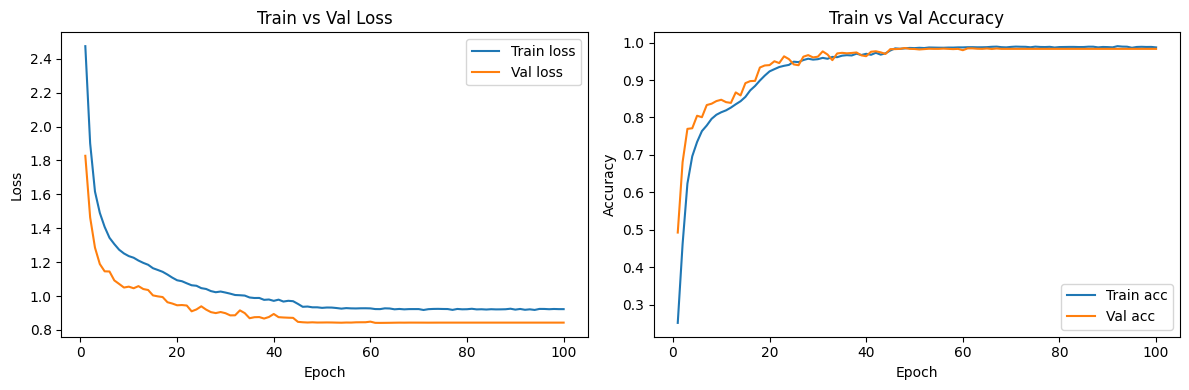

In [57]:
# -------------------------
# Plot and save
# -------------------------
ts = datetime.now().strftime("%Y%m%d_%H%M")
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Val Loss"); plt.legend()
# Acc
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train acc")
plt.plot(epochs_range, val_accs, label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Train vs Val Accuracy"); plt.legend()
plt.tight_layout()
plot_path = f"/kaggle/working/{MODEL_NAME}_train_val_{ts}.png"
plt.savefig(plot_path)
print("Saved plot to:", plot_path)
plt.show()

## Best vs Completed McNemar statistic

In [58]:
# contingency matrix:
# b = model A correct, model B incorrect
# c = model A incorrect, model B correct
b = np.sum((y_pred_A == y_true_A) & (y_pred_B != y_true_A))
c = np.sum((y_pred_A != y_true_A) & (y_pred_B == y_true_A))

table = [[0, b],
         [c, 0]]

result = mcnemar(table, exact=False, correction=True)
print(f"McNemar statistic = {result.statistic:.4f}")
print(f"p-value = {result.pvalue:.4f}")


McNemar statistic = 0.0000
p-value = 1.0000


# Model FLOPs

In [59]:
# from thop import profile

# def report_current_model_flops(model, model_name="model"):
#     def _inner():
#         print(f"Computing FLOPs for {model_name}...")
#         dummy = torch.randn(1, 6, 300).to(device)
#         flops, params = profile(model, inputs=(dummy,), verbose=False)
#         print(f"{model_name} FLOPs:  {flops/1e6:.4f}M")
#         print(f"{model_name} Params: {params/1e6:.4f}M")

#     out_txt_path = f"/kaggle/working/{model_name}_flops.txt"
#     return capture_and_save_eval(_inner, out_txt_path, show_in_notebook=True)


# _ = report_current_model_flops(model, model_name=MODEL_NAME)

In [60]:
# best_weights_path = "/kaggle/input/calanet-gn-cls-weight-100-epoch-flops/pytorch/default/1/CALANet_best_weights_only.pth"
# completed_weights_path = "/kaggle/input/calanet-gn-cls-weight-100-epoch-flops/pytorch/default/1/CALANet_completed_weights_only.pth"

# y_true_A, y_pred_A, _ = run_evaluation_and_return_text(
#     best_weights_path,
#     f"/kaggle/working/{MODEL_NAME}_best_output.txt",
#     loader=test_loader,
# )

# y_true_B, y_pred_B, _ = run_evaluation_and_return_text
#     completed_weights_path,
#     f"/kaggle/working/{MODEL_NAME}_completed_output.txt",
#     loader=test_loader,
# )


# Zero shot

In [61]:
# MODEL_NAME = "KUHAR_WaveNet"

# # KU-HAR config (same as training)
# MODEL_CONFIGS["KUHAR_WaveNet"] = dict(
#     n_classes=18
# )

# kuhar_weights_path = "/kaggle/input/kuhar-wavenet/pytorch/default/1/KUHAR_WaveNet_best_weights_only.pth"

# # Build model and load KU-HAR weights
# model = get_model_by_name(MODEL_NAME, **MODEL_CONFIGS[MODEL_NAME]).to(device)
# state_dict = torch.load(kuhar_weights_path, map_location=device)
# # Drop any FLOP-profiler keys if present
# clean_st = {k: v for k, v in state_dict.items()
#             if not (k.endswith("total_ops") or k.endswith("total_params"))}
# model.load_state_dict(clean_st, strict=False)
# model.eval()


In [62]:
# kuhar_to_ucihar = {
#     11: 1,  # walking
#     15: 2,  # walking upstairs
#     16: 3,  # walking downstairs
#     1:  4,  # sitting # 4-4
#     0:  5,  # standing
#     5:  6,  # laying
# }


In [63]:
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# def zero_shot_eval_ucihar_with_kuhar_model(model, loader, label_map, out_txt_path):
#     results = {}

#     def _inner():
#         print("Zero-shot evaluation: KU-HAR trained model on UCI-HAR test set")
#         print("Using only samples where predicted KU-HAR label is in the mapping.")

#         all_ucihar_true = []
#         all_ucihar_pred = []

#         with torch.no_grad():
#             for Xb, yb in loader:
#                 Xb = Xb.to(device)
#                 yb = yb.to(device)  # UCI-HAR labels 0..5

#                 logits = model(Xb)            # shape (B, 18)
#                 kuhar_preds = logits.argmax(dim=1).cpu().numpy()
#                 ucihar_true = yb.cpu().numpy()

#                 for kt, yt in zip(kuhar_preds, ucihar_true):
#                     if kt in label_map:
#                         all_ucihar_true.append(yt)
#                         all_ucihar_pred.append(label_map[kt])
#                     # else: ignore sample (model predicted a KU-HAR class with no UCI mapping)

#         all_ucihar_true = np.asarray(all_ucihar_true)
#         all_ucihar_pred = np.asarray(all_ucihar_pred)

#         print(f"Kept {len(all_ucihar_true)} samples out of full UCI-HAR test set.")

#         acc = accuracy_score(all_ucihar_true, all_ucihar_pred)
#         macro_f1 = f1_score(all_ucihar_true, all_ucihar_pred, average="macro")

#         print(f"\nZero-shot Overall accuracy: {acc:.4f}")
#         print(f"Zero-shot Macro F1: {macro_f1:.4f}")

#         print("\nZero-shot classification report:")
#         print(classification_report(all_ucihar_true, all_ucihar_pred, digits=4))

#         print("\nZero-shot confusion matrix:")
#         print(confusion_matrix(all_ucihar_true, all_ucihar_pred))

#         results["true"] = all_ucihar_true
#         results["pred"] = all_ucihar_pred

#     text = capture_and_save_eval(_inner, out_txt_path, show_in_notebook=True)
#     return results.get("true"), results.get("pred"), text

# # Run zero-shot eval
# out_txt_path = "/kaggle/working/CALANet_zero_shot_UCIHAR.txt"
# y_true_zs, y_pred_zs, zs_text = zero_shot_eval_ucihar_with_kuhar_model(
#     model,
#     test_loader,       # UCI-HAR test loader
#     kuhar_to_ucihar,
#     out_txt_path
# )
